# **Intro M2**
In this notebook I set up semi-supervised VAE to predict cell type proportions from bulk data.
This is the M2 model structure.
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: cell-type proportion, sample-id, and everything else (slack).
To enforce this disentanglement, there are classification losses on the cell-type and smaple_id embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the no label is available for the cell-type proportion, the output of the classifier is used as the latent code.
When it is available, it is directly input into the latent code.
The model is depicted below, except there is an additional latent subspace for predicting the perturbation status.
This latent subspace is structured in the same was as the encoder for sample_id.



The experimental set-up is as follows:
All data is from Kang dataset.
We generate pesudobulks from the original data, which contains 8 samples and 1 stimulated and one ctrl condition per sample.
We either perturb all cells, a single cell-type, or no cell types. 
This is done when we generate the pseudobulks by sampling from either perturbed or non-perturbed cells within each sample.
This is denoted in the parameter `exp_id`, it can be "all-kang", "mono-kang", "b-kang", "cd4Naive-kang", or "none-kang"
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the "labeled" data (meaning each sample has a ground truth cell-type proportion and it is from the cell-type proportion) and 6 samples with unlabeled data (ground truth proportions are not used in training.)




This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae


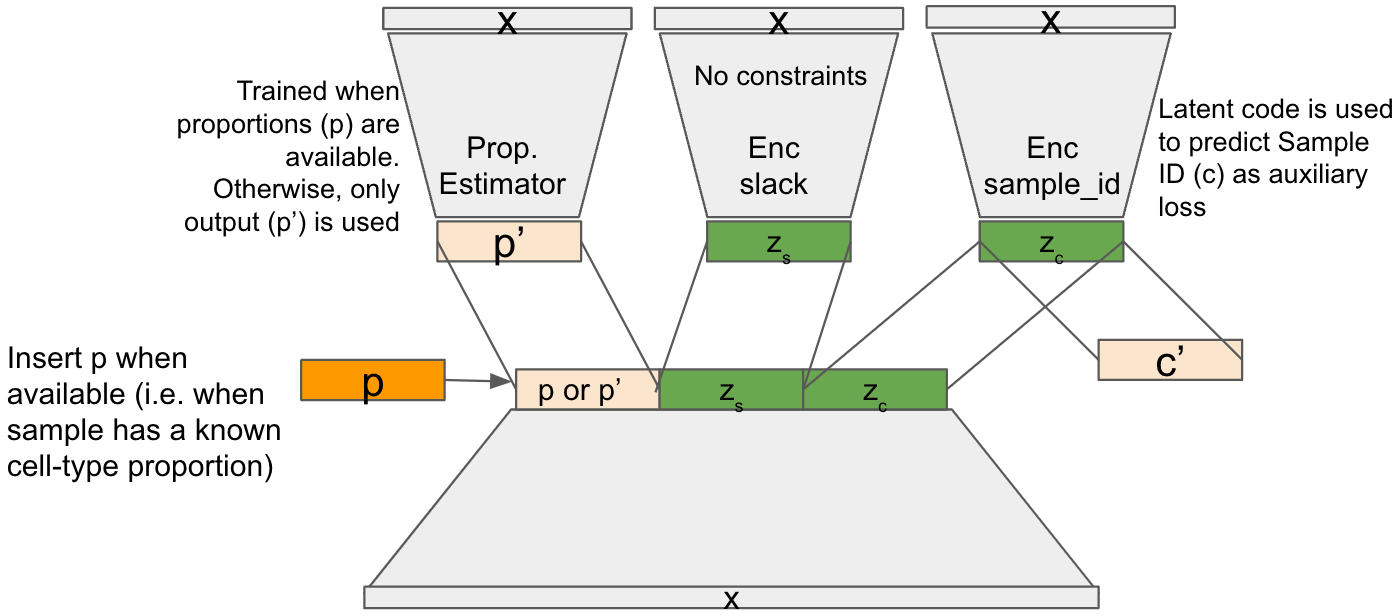

# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr, ttest_ind, wilcoxon
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess
from method_comparison import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [3]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)

<module 'method_comparison.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/exploratory_experiments/../method_comparison/validation_plotting.py'>

In [4]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kidney_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kidney/"
#cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_kidney/" +
#                        "CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses" +
#                        ".CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt")

# cibersort results
#cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job18_Results.csv"



num_genes = 7000

exp_id = "all-kidney"

# Set-up experimental variables

In [5]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 9

# number of patients/domains/samples expected
n_tot_samples = 3 # 3 "patients", old / young

# number of drugs (one-hot encoded)
n_drugs = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [6]:

pseudobulk_file = os.path.join(aug_data_path, f"{exp_id}_samp2_Test_Train_pseudo_splits.pkl")
prop_file = os.path.join(aug_data_path, f"{exp_id}_samp2_Test_Train_prop_splits.pkl")

gene_file = os.path.join(aug_data_path, f"{exp_id}_genes.pkl")
sig_file = os.path.join(aug_data_path, f"{exp_id}_sig.pkl")

pseudobulk_path = Path(pseudobulk_file)
prop_path = Path(prop_file)
gene_path = Path(gene_file)
sig_path = Path(sig_file)

prop_df = pickle.load( open( prop_path, "rb" ) )
pseudobulks_df = pickle.load( open( pseudobulk_path, "rb" ) )
gene_df = pickle.load( open( gene_path, "rb" ) )
sig_df = pickle.load( open( sig_path, "rb" ) )


NameError: name 'data_path' is not defined

In [27]:

##################################################
#####. Design the experiment
##################################################

# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kidney_pseudobulk_files(aug_data_path, exp_id, num_bulks_training=10)
X_full.columns = gene_df

X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "all-kidney_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
#cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
#cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
#cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
gene_df = gene_df.iloc[idx_top]


samp2
STIM
Train
Test
CTRL
Train
Test
samp3
STIM
Train
Test
CTRL
Train
Test


In [28]:
X_train_df

gene_ids Xkr4  Rp1  Sox17 Mrpl15 Lypla1 Tcea1 Atp6v1h Rb1cc1 St18 Pcmtd1  ...  \
0          32   45   1814  11068  11085  3436    7499   7034    0   6644  ...   
0          58  417  22849   7866   8689  3608    6304   9046    0  12237  ...   
0           0    0    853  10391  14751  2813    5875   6160    0   5219  ...   
0           0    0    805  11507  17670  3616    6143  10107    0  12558  ...   
0           3    0   1331   6701  11530  2691    5782   8384    0   8375  ...   
..        ...  ...    ...    ...    ...   ...     ...    ...  ...    ...  ...   
0         178   55     35   2738   3710  1690   14652  62498  302   2841  ...   
0          36  165    275   2247   2505  1515   14877  56841  867   3191  ...   
0          33  246    183   2889   3092  1781   16850  71324  403   3977  ...   
0         132  198    468   2984   3575  1942   17401  61344  313   4069  ...   
0          18  197    769   2964   3058  1718   14683  60377  364   3248  ...   

gene_ids Spry3 Tmlhe Zf12 Kdm5d Eif2s3y   Uty Ddx3y Usp9y Rbmy1a1 Erdr1  
0            0   545  151  3220    1511  2680   597    18     187  2641  
0            0   750  132  2112    1869  3086   793   623     782  2339  
0            0   193   22  1835    1149  1775   452   340     284  1576  
0            0    16  165  2218    1679  3145   488   560       0  4258  
0            0    19  183  1362    1431  2212   494   546     114  2874  
..         ...   ...  ...   ...     ...   ...   ...   ...     ...   ...  
0            0    46  219  1332    4669  3158  4415     0    1170  4429  
0            0    39  140  1502    5065  2386  4948     0    1934  4441  
0            0    21  151  2028    4804  3298  5882     0    1304  4869  
0            0    59  122  1394    5369  3048  5583     0    1261  4991  
0            0    77   88  1791    5426  2479  4597     0     566  4197  

[1940 rows x 16649 columns]

In [29]:
X_train

array([[32, 45, 1814, ..., 18, 187, 2641],
       [58, 417, 22849, ..., 623, 782, 2339],
       [0, 0, 853, ..., 340, 284, 1576],
       ...,
       [33, 246, 183, ..., 0, 1304, 4869],
       [132, 198, 468, ..., 0, 1261, 4991],
       [18, 197, 769, ..., 0, 566, 4197]], dtype=object)

In [30]:

#venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
#plt.show()

In [31]:
union_genes = gene_df #np.union1d(gene_df, cibersort_genes)


In [32]:
def pearsonr_2D(x, y):
    """computes pearson correlation coefficient
       where x is a 1D and y a 2D array"""

    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    
    rho = upper / lower
    
    return rho

In [33]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()



[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5940 samples in 0.023s...
[t-SNE] Computed neighbors for 5940 samples in 2.562s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5940
[t-SNE] Computed conditional probabilities for sample 2000 / 5940
[t-SNE] Computed conditional probabilities for sample 3000 / 5940
[t-SNE] Computed conditional probabilities for sample 4000 / 5940
[t-SNE] Computed conditional probabilities for sample 5000 / 5940
[t-SNE] Computed conditional probabilities for sample 5940 / 5940
[t-SNE] Mean sigma: 1.493774
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.438309
[t-SNE] KL divergence after 500 iterations: 0.830193
(5940, 2)
(5940, 2)


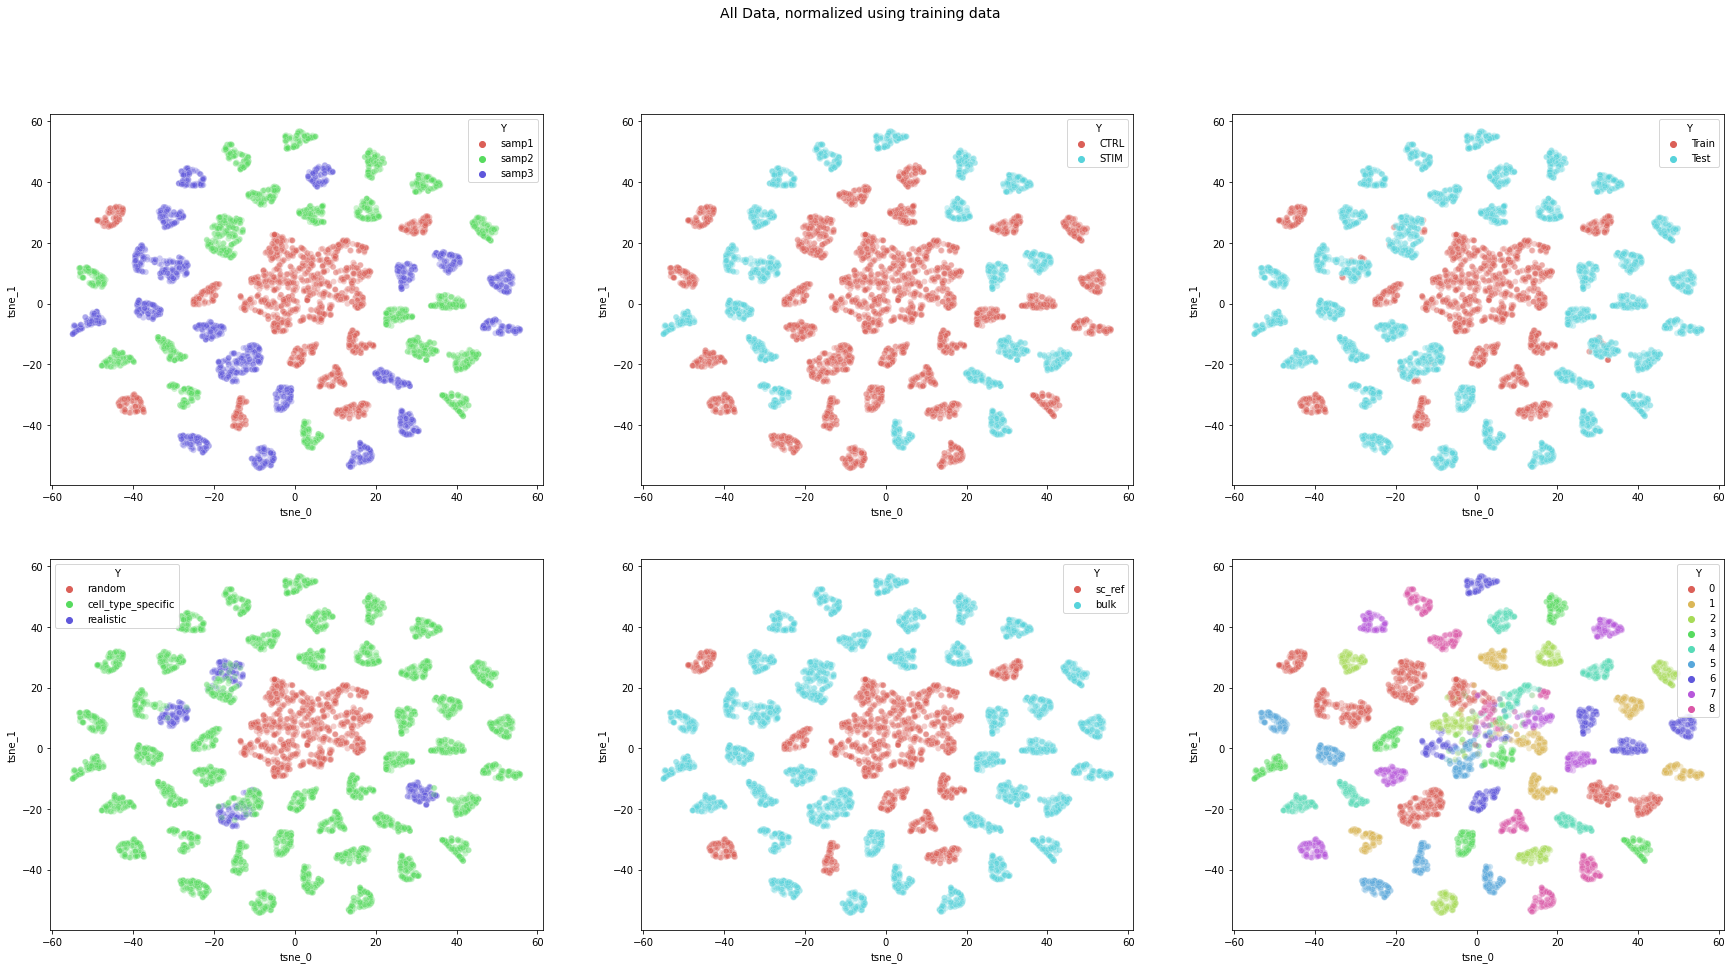

In [34]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()


(4040, 2)
(4040, 2)


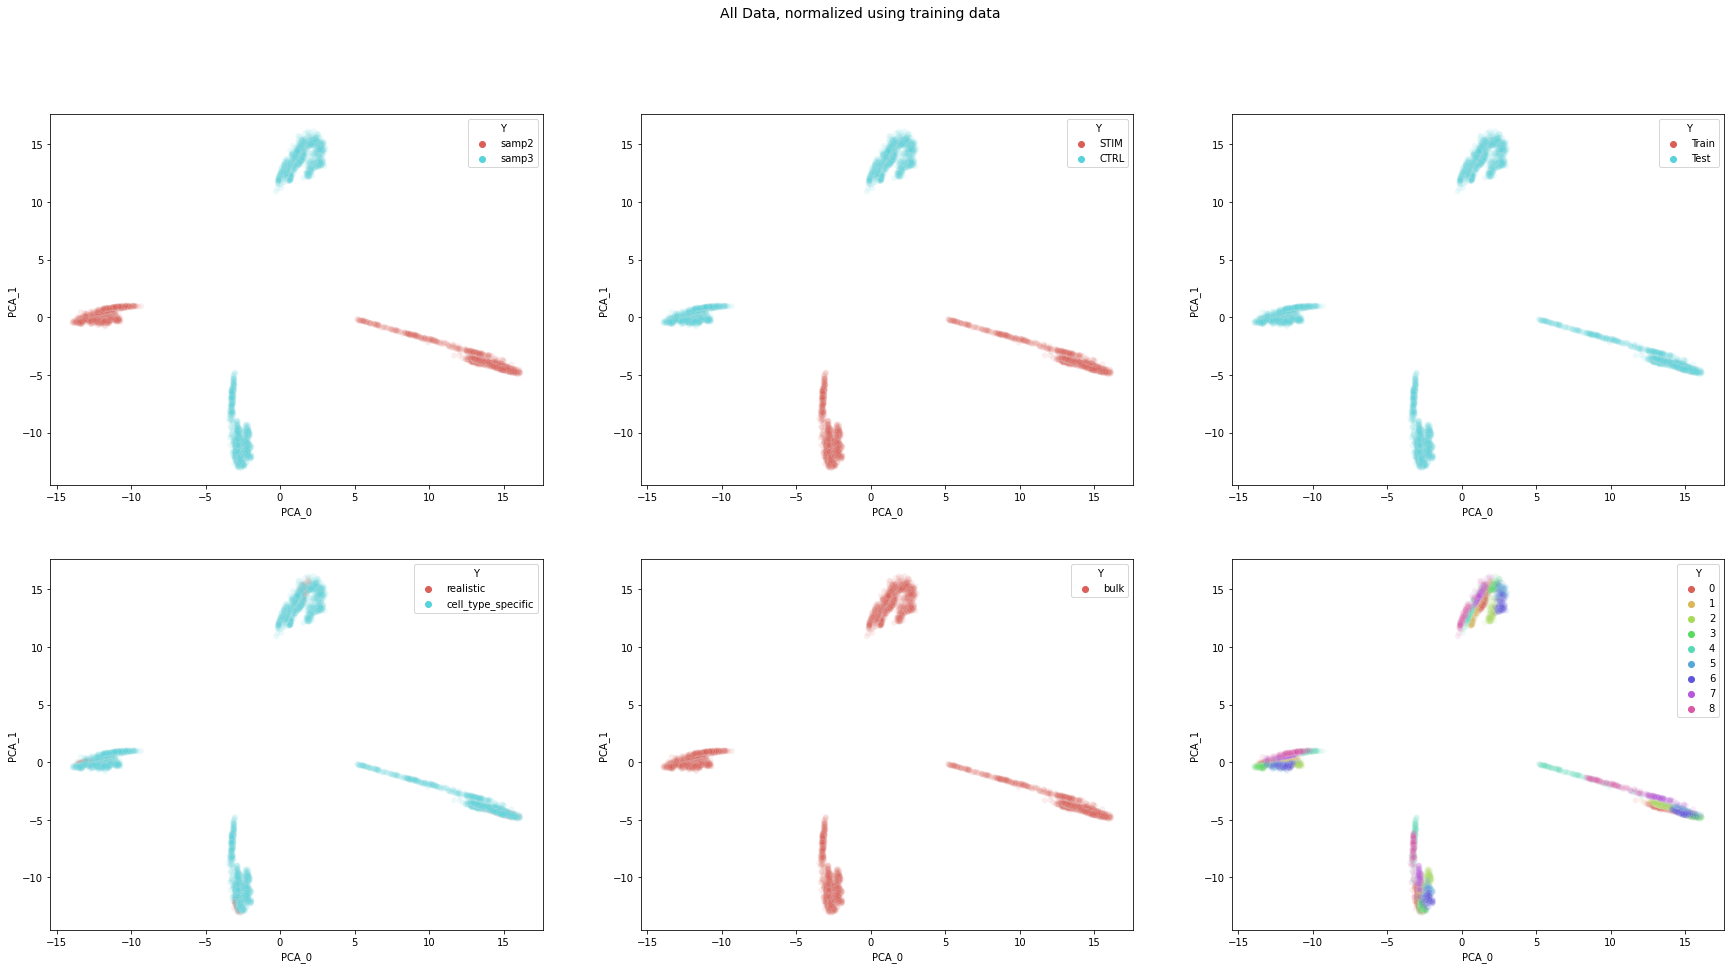

In [35]:
## plot samples
idx_interest = np.where(meta_df.samp_type == "bulk")[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()


(2020, 2)
(2020, 2)


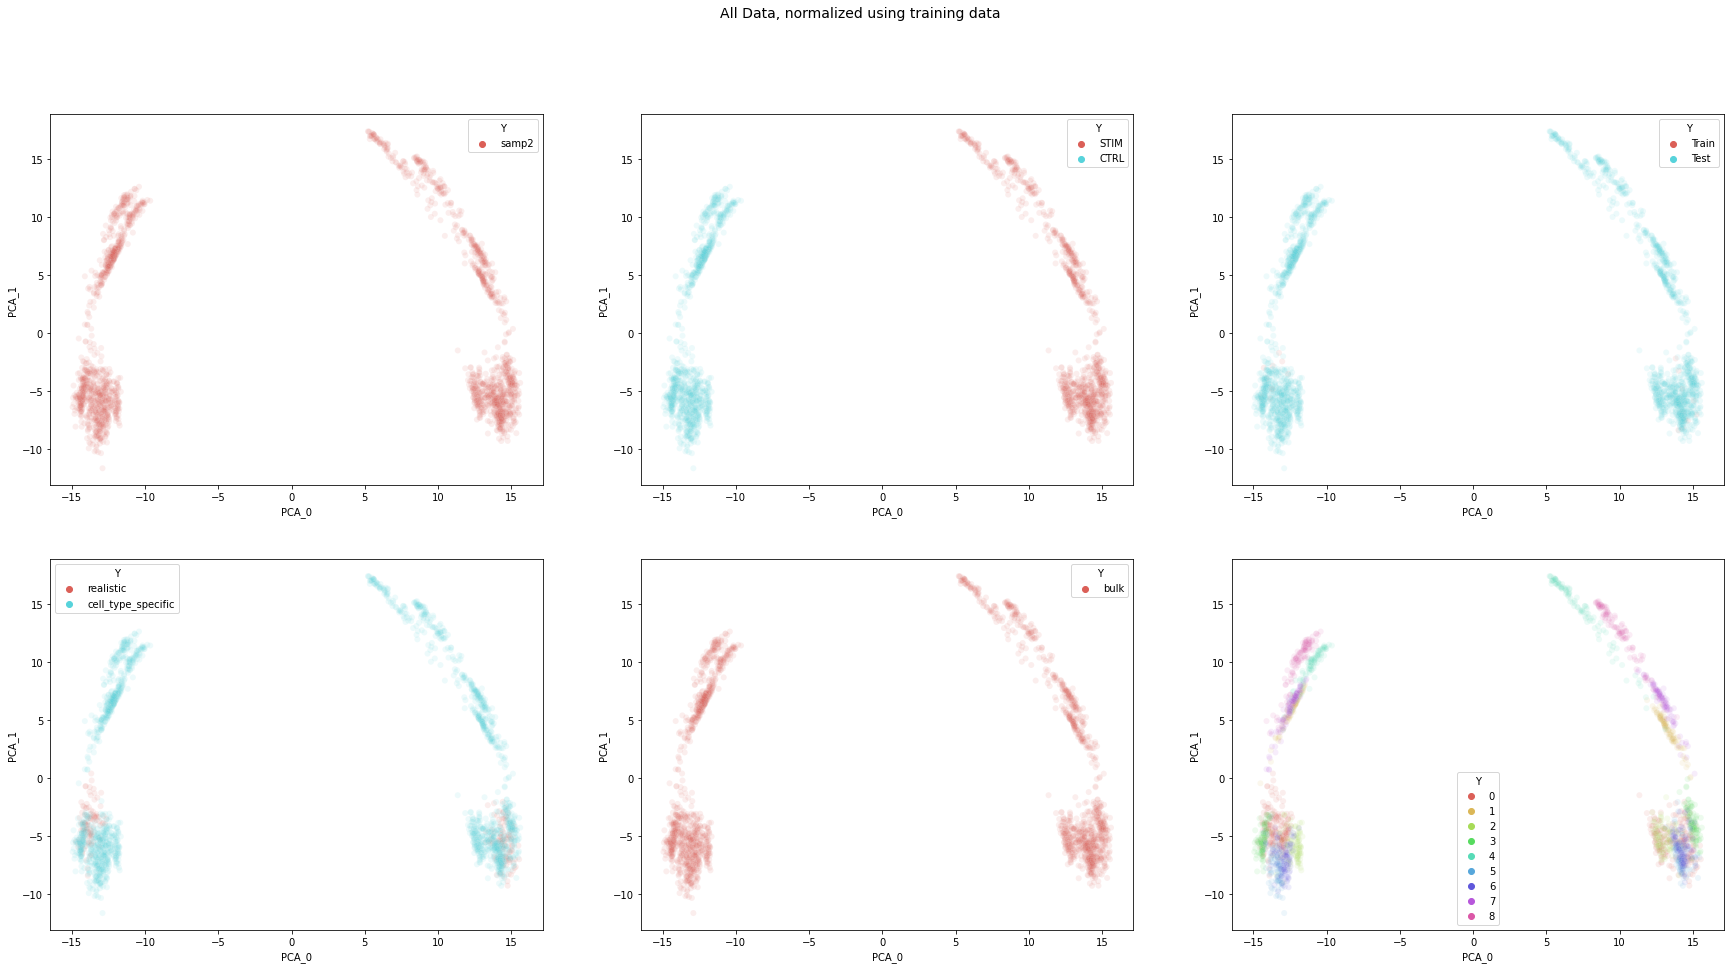

In [36]:
idx_interest = np.logical_and(meta_df.samp_type == "bulk", meta_df.sample_id == "samp2")
idx_interest = np.where(idx_interest)[0]


plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()



# **M2 Model Definition**

## Hyperparameters

In [37]:

##################################################
#####. Hyperparameters
##################################################

batch_size = 500
n_epoch = 100 # 500 

alpha_rot = 1000000 #1000000
alpha_drug = 10000 #1000000
alpha_prop = 100 #100

beta_kl_slack = 0.1 # 10 ###
beta_kl_rot = 100 # 100 ###
beta_kl_drug = 100 # 100 ###


n_x = X_full.shape[1]
n_y = Y_full.shape[1]
n_label = n_tot_samples  # 8 donors 
n_drugs = n_drugs  # number of drugs one-hot encoded
n_label_z = 64  # 64 dimensional representation of rotation


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = Y_full.shape[1] # latent space size, one latent dimension PER cell type
encoder_dim = 512 # dim of encoder hidden layer 512 
decoder_dim = 512 # dim of encoder hidden layer 512 
decoder_out_dim = n_x # dim of decoder output layer

# labeled classifier
class_dim1 = 512 # 512 
class_dim2 = 256 # 256 


activ = 'relu'
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005) #0.001
print(f"length of X {n_x} and length of y {n_y} n_label {n_label} and n_drugs {n_drugs}")



length of X 7000 and length of y 9 n_label 3 and n_drugs 2


## Encoder + Y classifier

In [38]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
Y = Input(shape=(n_y,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))
z_in = Input(shape=(n_y+n_label_z+n_label_z+n_label_z,))
cls_in = Input(shape=(n_label_z,))

inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_s = Dense(encoder_dim, activation=activ, name="encoder_slack")(inputs)
encoder_r = Dense(encoder_dim, activation=activ, name="encoder_rot")(inputs)
encoder_d = Dense(encoder_dim, activation=activ, name="encoder_drug")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_label_z, activation='linear', name = "mu_slack")(encoder_s)
l_sigma_slack = Dense(n_label_z, activation='linear', name = "sigma_slack")(encoder_s)

mu_rot = Dense(n_label_z, activation='linear', name = "mu_rot")(encoder_r)
l_sigma_rot = Dense(n_label_z, activation='linear', name = "sigma_rot")(encoder_r)


mu_drug = Dense(n_label_z, activation='linear', name = "mu_drug")(encoder_d)
l_sigma_drug = Dense(n_label_z, activation='linear', name = "sigma_drug")(encoder_d)



# set up labeled classifier
#defining the architecture of the classifier

class_hidden1 = Dense(class_dim1, activation=activ, name = "cls_h1")
class_hidden2 = Dense(class_dim2, activation=activ, name="cls_h2")
class_out = Dense(n_y, activation='softmax', name="cls_out")

#x_concat_lab = tf.keras.layers.concatenate([inputs, label])
#classifier_h1 = class_hidden1(tf.keras.layers.Concatenate()([inputs, label]))
classifier_h1 = class_hidden1(inputs)
classifier_h2 = class_hidden2(classifier_h1)
Y_cls = class_out(classifier_h2)



## Latent Space

In [39]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_label_z])
z_rot = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label_z])
z_drug = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_drug")([mu_drug, l_sigma_drug, n_label_z])

z_concat_lab = concat([z_slack, Y, z_rot, z_drug])
z_concat_unlab = concat([z_slack, Y_cls, z_rot, z_drug])

## Decoder + Classifiers

In [40]:
def null_f(args):
    return args

###### DECODER
# set up decoder network
# this is a decoder with 512 hidden layer
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

d_in = Input(shape=(n_label_z+n_y+n_label_z+n_label_z,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)

# set up the decoder part that links to the encoder
# labeled decoder
h_lab = decoder_hidden(z_concat_lab)
outputs_lab = decoder_out(h_lab)

# unlabeled decoder
h_unlab = decoder_hidden(z_concat_unlab)
outputs_unlab = decoder_out(h_unlab)


###### Rotations classifier
# this is the rotation we try to estimate
rot_h1 = ReLU(name = "rot_h1")
rot_h2 = Dense(n_label, activation='linear', name = "rot_h2")
rot_softmax = Softmax(name = "mu_rot_pred")
decoder_sigma_r = Lambda(null_f, name = "l_sigma_rot_pred")


rot_1_out = rot_h1(z_rot)
rot_2_out = rot_h2(rot_1_out)
rotation_outputs = rot_softmax(rot_2_out)
sigma_outputs_r = decoder_sigma_r(l_sigma_rot)



###### Drug classifier
# this is the drug we try to estimate
drug_h1 = ReLU(name = "drug_h1")
drug_h2 = Dense(n_drugs, activation='linear', name = "drug_h2")
drug_softmax = Softmax(name = "mu_drug_pred")
decoder_sigma_d = Lambda(null_f, name = "l_sigma_drug_pred")


drug_1_out = drug_h1(z_drug)
drug_2_out = drug_h2(drug_1_out)
drug_outputs = drug_softmax(drug_2_out)
sigma_outputs_d = decoder_sigma_d(l_sigma_drug)








## Loss

In [41]:

def vae_loss(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_drug = beta_kl_drug * K.sum(K.exp(l_sigma_drug) + K.square(mu_drug) - 1. - l_sigma_drug, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_rot +kl_drug+ kl_slack


def recon_loss(y_true, y_pred):
	return K.sum(mean_squared_error(y_true, y_pred), axis=-1)


def prop_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_prop

def drug_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_drug


def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)*alpha_rot
    return recon



## Make the computational graph

In [42]:
classifier = Model(X, Y_cls)

known_prop_vae = Model([X, Y], [outputs_lab, Y_cls, rotation_outputs, drug_outputs])
unknown_prop_vae = Model(X, [outputs_unlab, rotation_outputs, drug_outputs])

known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss, drug_loss]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss, class_loss, drug_loss]) #, metrics = [KL_loss, recon_loss])

encoder_unlab = Model(X, [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug])

encoder_lab = Model([X, Y], [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug])


decoder = Model(d_in, d_out)


print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7000)]       0           []                               
                                                                                                  
 encoder_slack (Dense)          (None, 512)          3584512     ['input_1[0][0]']                
                                                                                                  
 encoder_rot (Dense)            (None, 512)          3584512     ['input_1[0][0]']                
                                                                                                  
 encoder_drug (Dense)           (None, 512)          3584512     ['input_1[0][0]']                
                                                                                            

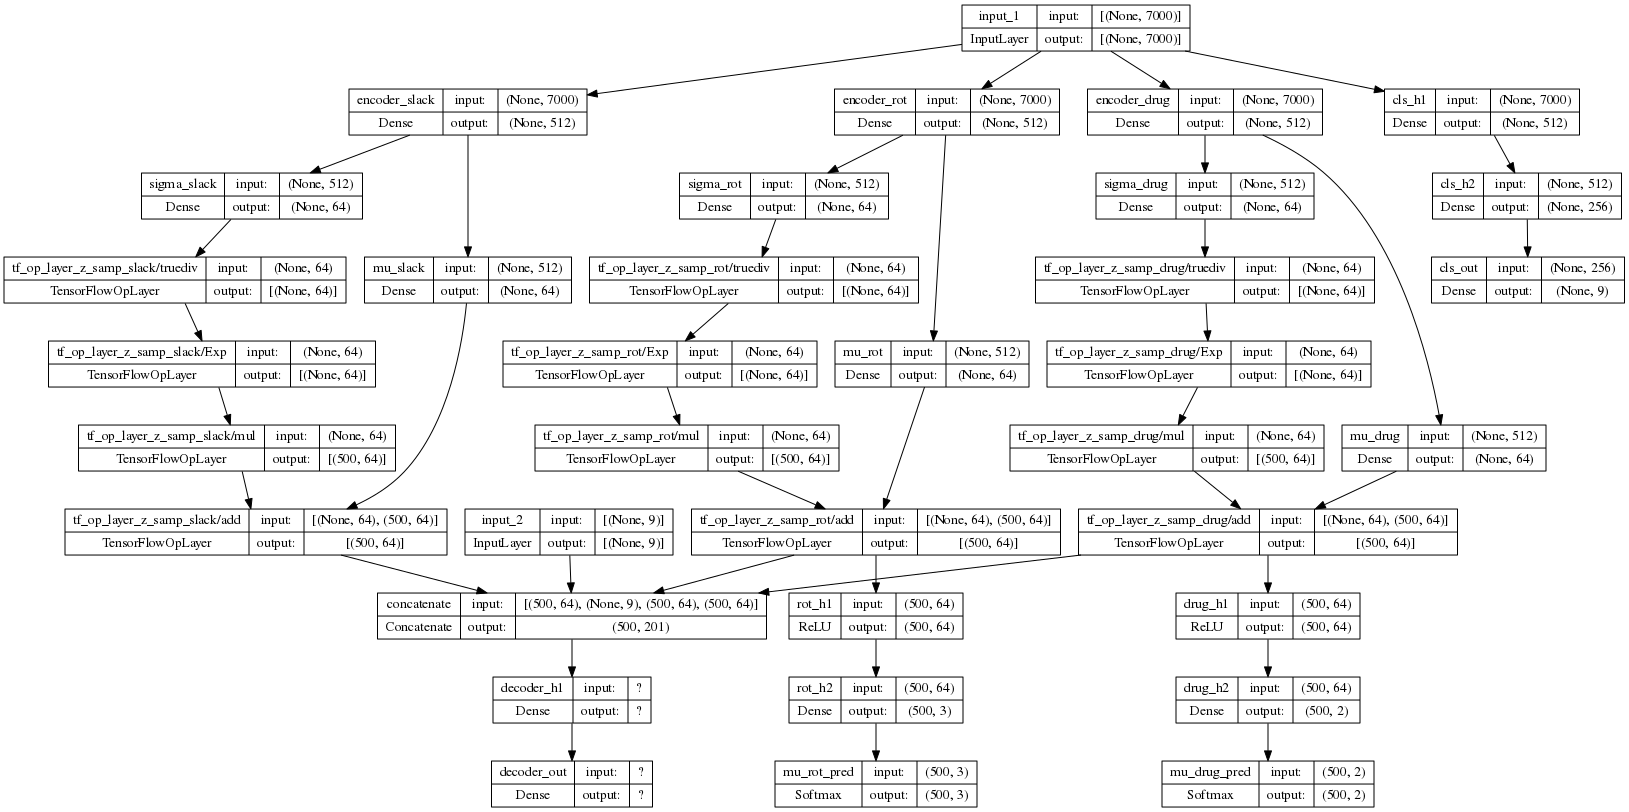

In [43]:
display(plot_model(known_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

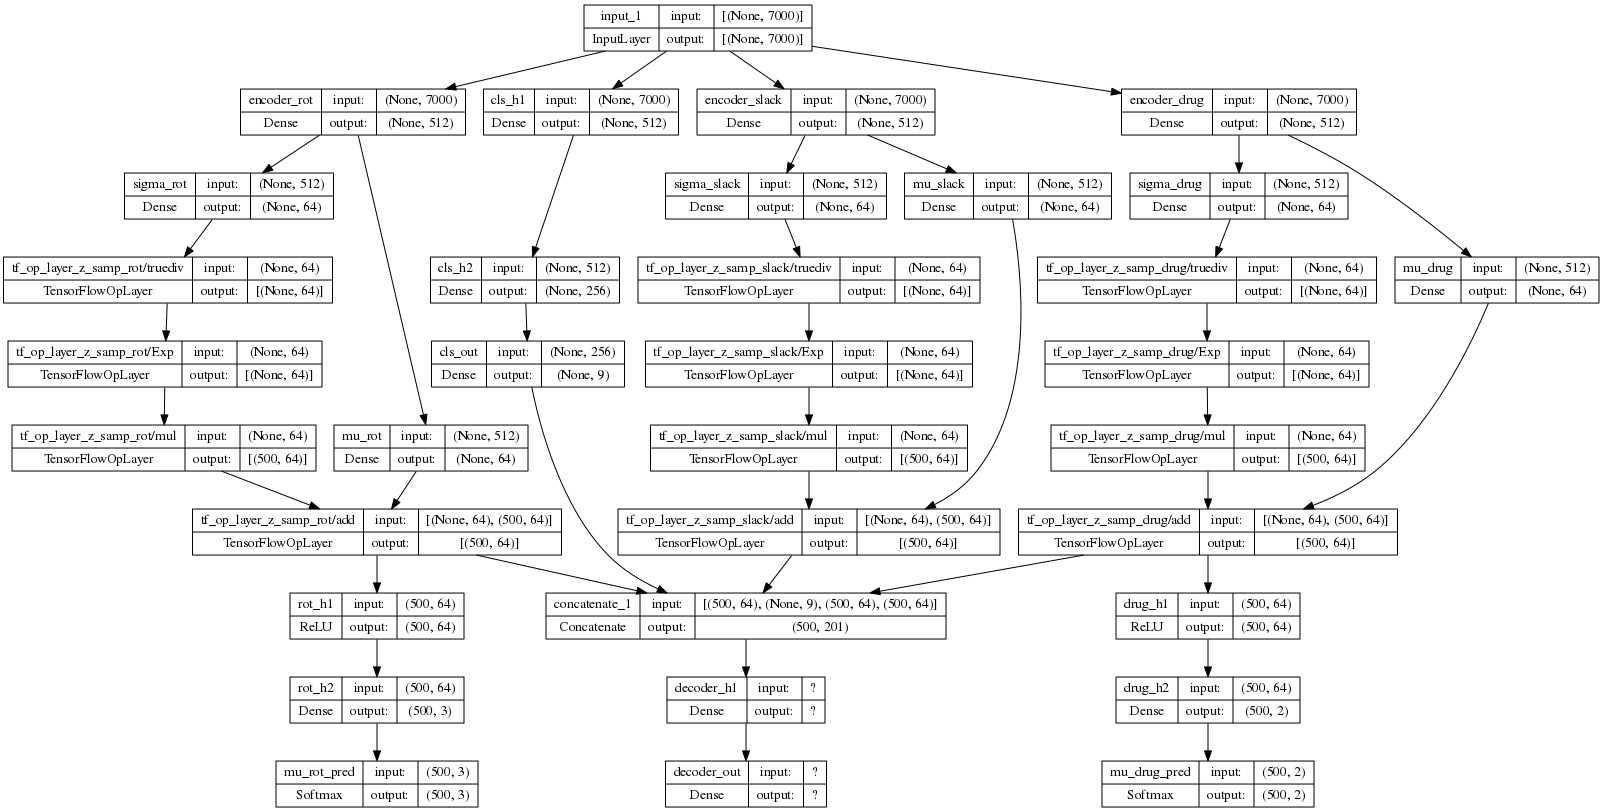

In [44]:
display(plot_model(unknown_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [45]:


def fit_model(X_unknown_prop, label_unknown_prop, drug_unknown_prop, X_known_prop, Y_known_prop, label_known_prop, drug_known_prop, epochs):
    assert len(X_unknown_prop) % len(X_known_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    meta_hist = []
    
    for epoch in range(epochs):
        unlabeled_index = np.arange(len(X_unknown_prop))
        np.random.shuffle(unlabeled_index)

        # Repeat the unlabeled data to match length of labeled data
        labeled_index = []
        for i in range(len(X_unknown_prop) // len(X_known_prop)):
            l = np.arange(len(X_known_prop))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        for i in range(batches):
            # Labeled
            index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
            loss = known_prop_vae.train_on_batch([X_known_prop[index_range], Y_known_prop[index_range]],
                                                    [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range], drug_known_prop[index_range]])
            meta_hist.append(i)

            # Unlabeled
            index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
            loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range],
                                                        [X_unknown_prop[index_range], label_unknown_prop[index_range], drug_unknown_prop[index_range]])]

            meta_hist.append(i)

            history.append(loss)
            
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return [history, meta_hist]

In [46]:
for layer in classifier.layers:
    print(layer)

In [47]:
for layer in encoder_unlab.layers:
    print(layer.name)

input_1
encoder_slack
encoder_rot
encoder_drug
sigma_slack
sigma_rot
sigma_drug
tf_op_layer_z_samp_slack/truediv
tf_op_layer_z_samp_rot/truediv
tf_op_layer_z_samp_drug/truediv
tf_op_layer_z_samp_slack/Exp
tf_op_layer_z_samp_rot/Exp
tf_op_layer_z_samp_drug/Exp
mu_slack
tf_op_layer_z_samp_slack/mul
mu_rot
tf_op_layer_z_samp_rot/mul
mu_drug
tf_op_layer_z_samp_drug/mul
tf_op_layer_z_samp_slack/add
tf_op_layer_z_samp_rot/add
tf_op_layer_z_samp_drug/add


Now train

In [48]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


In [54]:
X_unkp.shape

(40, 7000)

In [55]:
# X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop
loss_history = fit_model(np.repeat(X_unkp, 950, axis=0),
                    np.repeat(label_unkp, 950, axis=0),
                    np.repeat(drug_unkp, 950, axis=0),
                    X_kp, 
                    y_kp,
                    label_kp, 
                    drug_kp, epochs=n_epoch)



Elapsed:  3543.872559785843


In [56]:
meta_history = loss_history[1]
loss_history = loss_history[0]

# Plot Loss Curves

In [57]:
# write out the loss for later plotting
# unpack the loss values
labeled_total_loss = [item[0] for item in loss_history]
unlabeled_total_loss = [item[5][0] for item in loss_history]

labeled_recon_loss = [item[1] for item in loss_history]
unlabeled_recon_loss = [item[5][1] for item in loss_history]

labeled_prop_loss = [item[2] for item in loss_history]

labeled_samp_loss = [item[3] for item in loss_history]
unlabeled_samp_loss = [item[5][2] for item in loss_history]

labeled_drug_loss = [item[4] for item in loss_history]
unlabeled_drug_loss = [item[5][2] for item in loss_history]


# make into a dataframe
total_loss = labeled_total_loss + unlabeled_total_loss + [a + b for a, b in zip(labeled_total_loss, unlabeled_total_loss)]
loss_df = pd.DataFrame(data=total_loss, columns=['total_loss'])
loss_df['type'] = ["labeled"]*len(loss_history) + ["unlabeled"]*len(loss_history) + ["sum"]*len(loss_history)
loss_df['batch'] = [*range(len(loss_history))] + [*range(len(loss_history))] + [*range(len(loss_history))]

recon_loss = labeled_recon_loss + unlabeled_recon_loss + [a + b for a, b in zip(labeled_recon_loss, unlabeled_recon_loss)]
loss_df['recon_loss'] = recon_loss

prop_loss = labeled_prop_loss + [0]*len(loss_history) + labeled_prop_loss
loss_df['prop_loss'] = prop_loss

samp_loss = labeled_samp_loss + unlabeled_samp_loss + [a + b for a, b in zip(labeled_samp_loss, unlabeled_samp_loss)]
loss_df['samp_loss'] = samp_loss


drug_loss = labeled_drug_loss + unlabeled_drug_loss + [a + b for a, b in zip(labeled_drug_loss, unlabeled_drug_loss)]
loss_df['drug_loss'] = drug_loss



In [58]:
loss_df

total_loss     type  batch     recon_loss    prop_loss     samp_loss  \
0      6.722291e+06  labeled      0    6617.748535  7465.177246  3.402573e+06   
1      7.786964e+05  labeled      1  131206.578125  7453.566895  6.400355e+05   
2      1.095169e+06  labeled      2  268520.125000  7139.382812  8.195095e+05   
3      7.021858e+05  labeled      3  338381.093750  6980.353516  3.568242e+05   
4      6.054958e+05  labeled      4  389966.593750  7007.769043  2.085212e+05   
...             ...      ...    ...            ...          ...           ...   
22795  7.598862e+03      sum   7595    6635.140137   223.293930  3.983347e+02   
22796  7.310241e+03      sum   7596    6492.636719   131.695465  5.156155e+02   
22797  7.397092e+03      sum   7597    6501.637695   188.763550  5.007391e+02   
22798  8.217016e+03      sum   7598    6410.122070   163.341156  4.272374e+02   
22799  7.436597e+03      sum   7599    6640.611816   164.783035  4.124962e+02   

          drug_loss  
0      3.305635e+06  
1      7.492486e-01  
2      1.488952e-01  
3      1.478264e-01  
4      1.478197e-01  
...             ...  
22795  3.591517e+02  
22796  3.693491e+02  
22797  3.594740e+02  
22798  3.738177e+02  
22799  2.524726e+02  

[22800 rows x 7 columns]

In [59]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

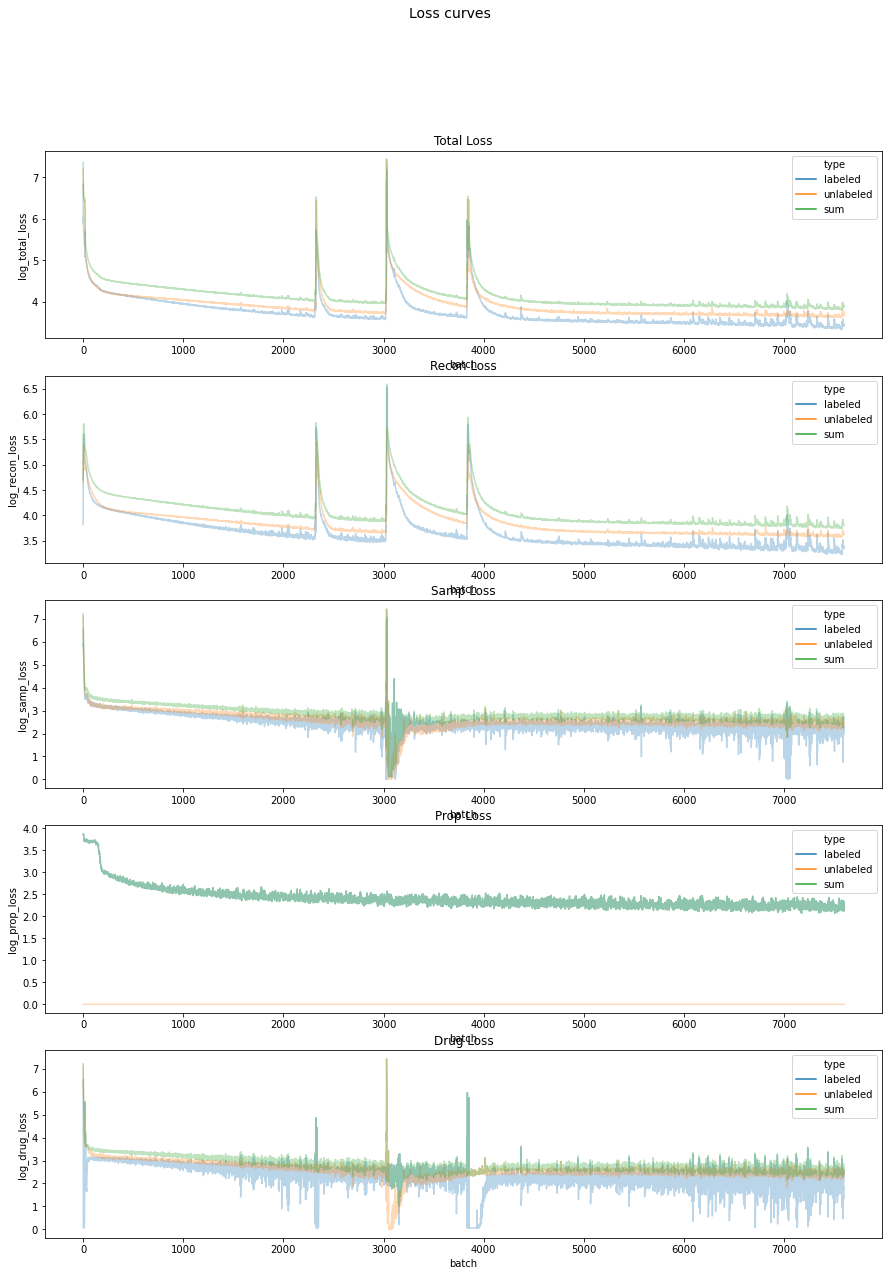

In [60]:

# add the log to make it easier to plot
loss_df["log_total_loss"] = np.log10(loss_df["total_loss"]+1)
loss_df["log_recon_loss"] = np.log10(loss_df["recon_loss"]+1)
loss_df["log_samp_loss"] = np.log10(loss_df["samp_loss"]+1)
loss_df["log_prop_loss"] = np.log10(loss_df["prop_loss"]+1)
loss_df["log_drug_loss"] = np.log10(loss_df["drug_loss"]+1)


fig, axs = plt.subplots(5, figsize=(15,20))

make_loss_fig(loss_df, ax=axs[0], title=f"Total Loss", loss_to_plot="log_total_loss")
make_loss_fig(loss_df, ax=axs[1], title=f"Recon Loss", loss_to_plot="log_recon_loss")
make_loss_fig(loss_df, ax=axs[2], title=f"Samp Loss", loss_to_plot="log_samp_loss")
make_loss_fig(loss_df, ax=axs[3], title=f"Prop Loss", loss_to_plot="log_prop_loss")
make_loss_fig(loss_df, ax=axs[4], title=f"Drug Loss", loss_to_plot="log_drug_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()

In [61]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab, class_id):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g


def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


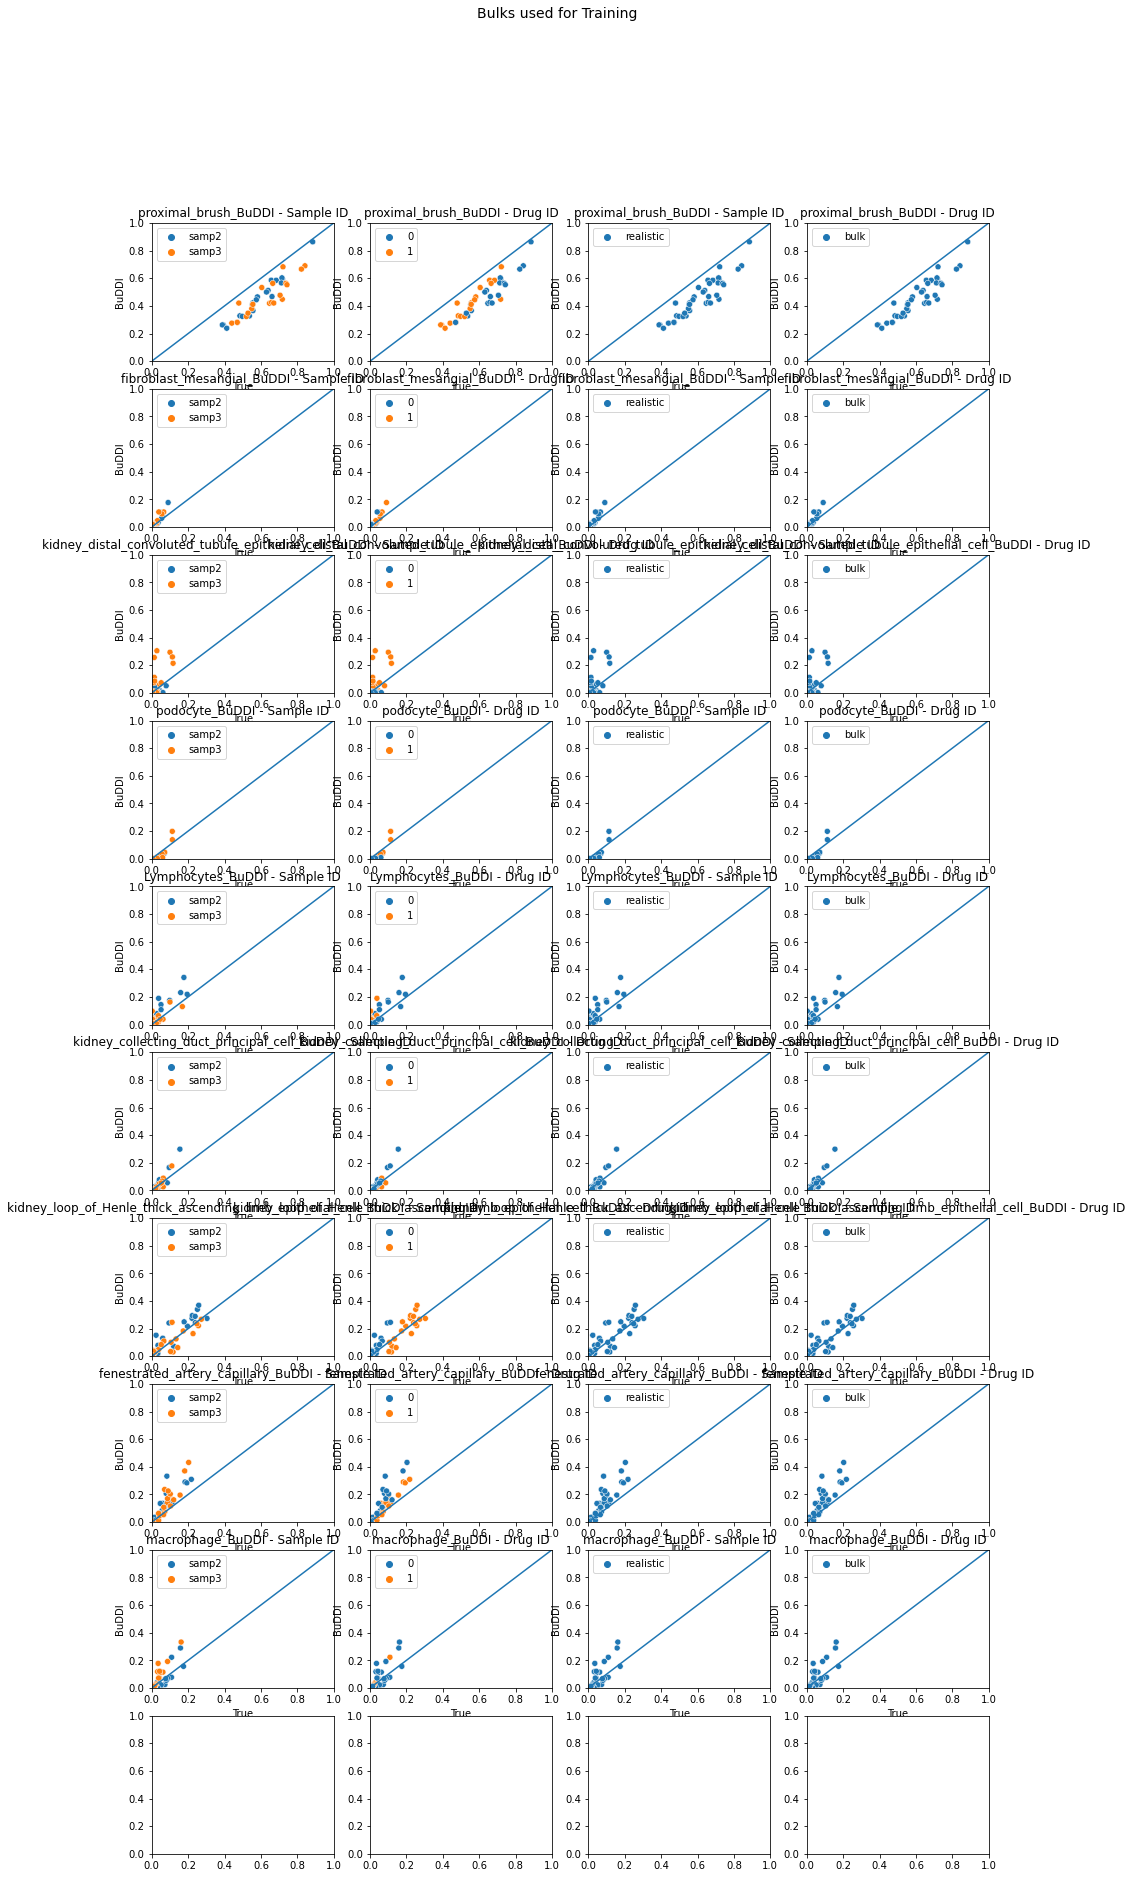

In [62]:
idx_tmp = np.intersect1d(idx_bulk, idx_train)
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = index_label[label_temp]



fig, axs = plt.subplots(9, 4, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=label_temp[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,2], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=meta_df.cell_prop_type.to_numpy()[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,3], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=meta_df.samp_type.to_numpy()[idx_tmp])
        
    row_idx = row_idx +1


fig.suptitle("Bulks used for Training", fontsize=14)

fig.show()

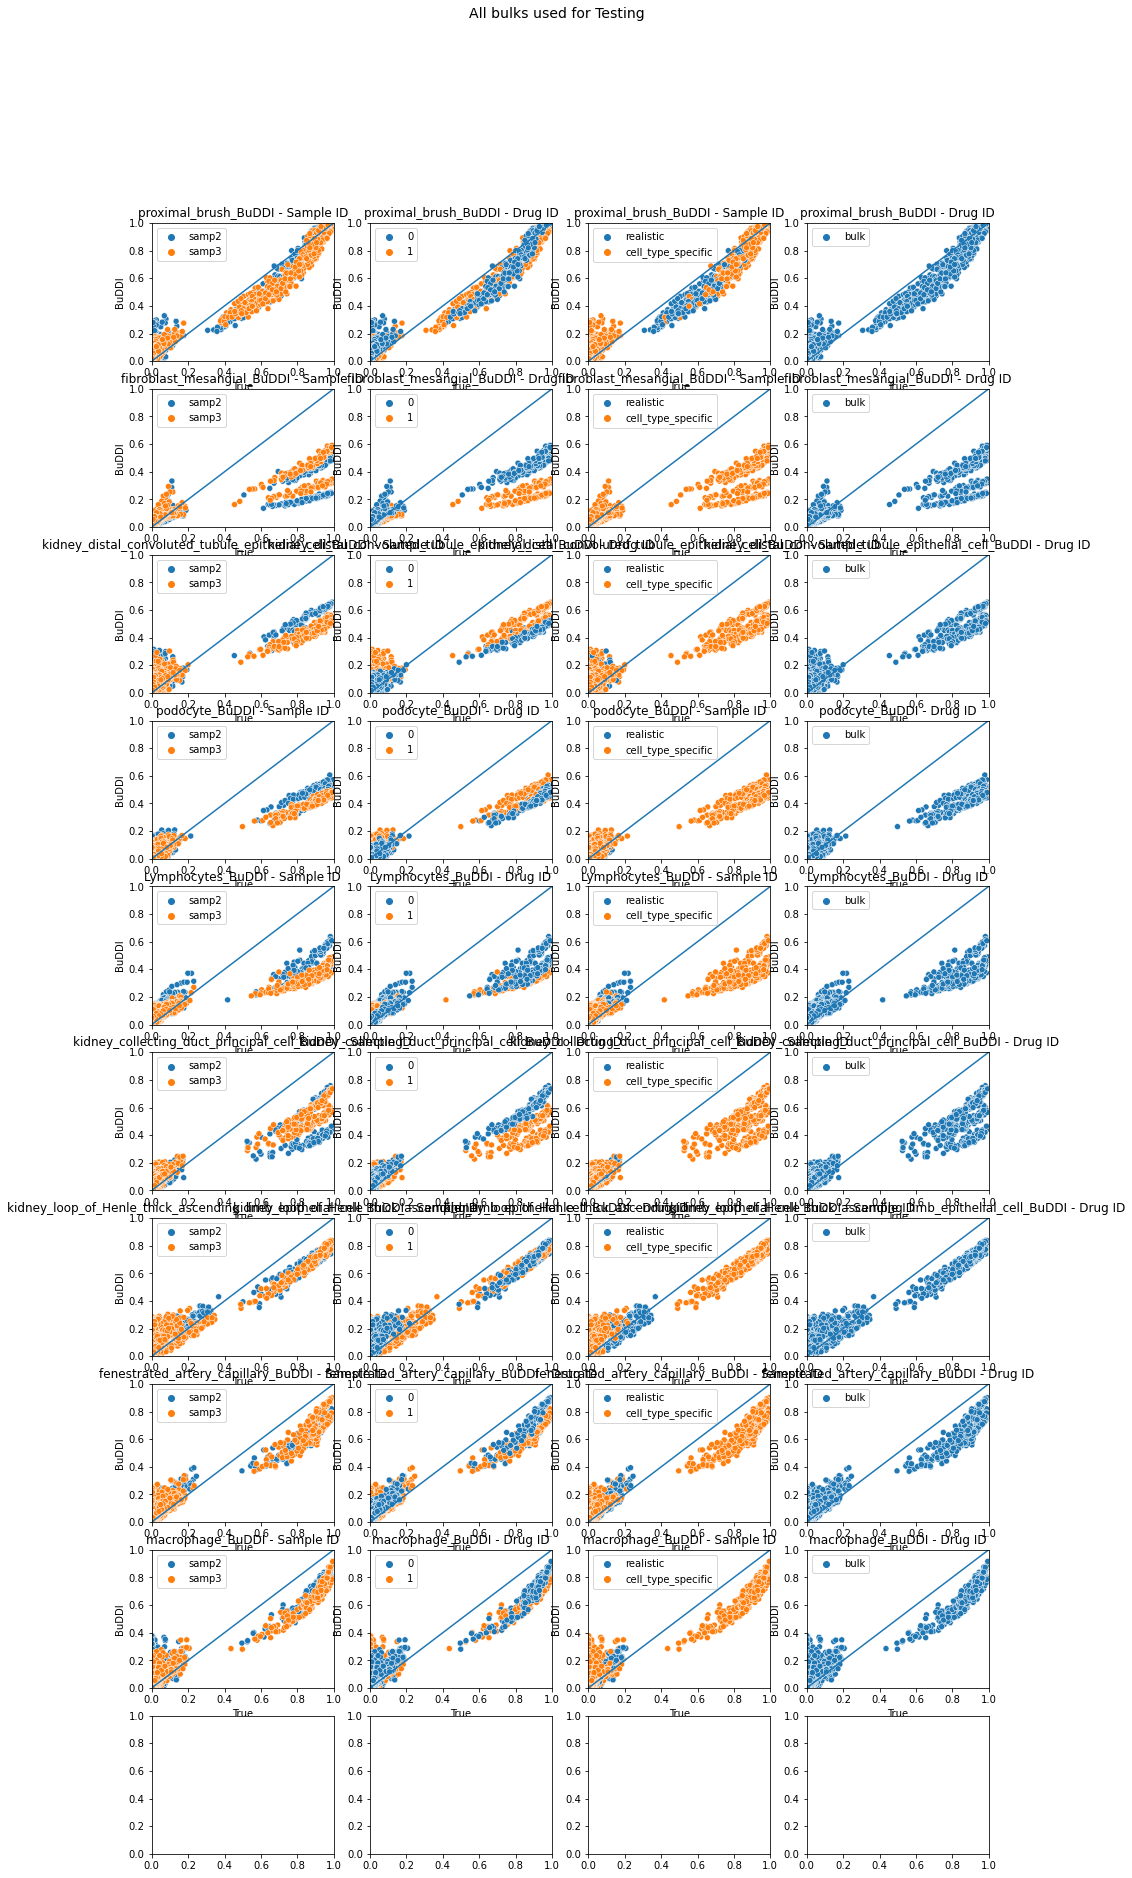

In [63]:
idx_tmp = idx_test
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = index_label[label_temp]



fig, axs = plt.subplots(9, 4, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=label_temp[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,2], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=meta_df.cell_prop_type.to_numpy()[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,3], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=meta_df.samp_type.to_numpy()[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("All bulks used for Testing", fontsize=14)

fig.show()

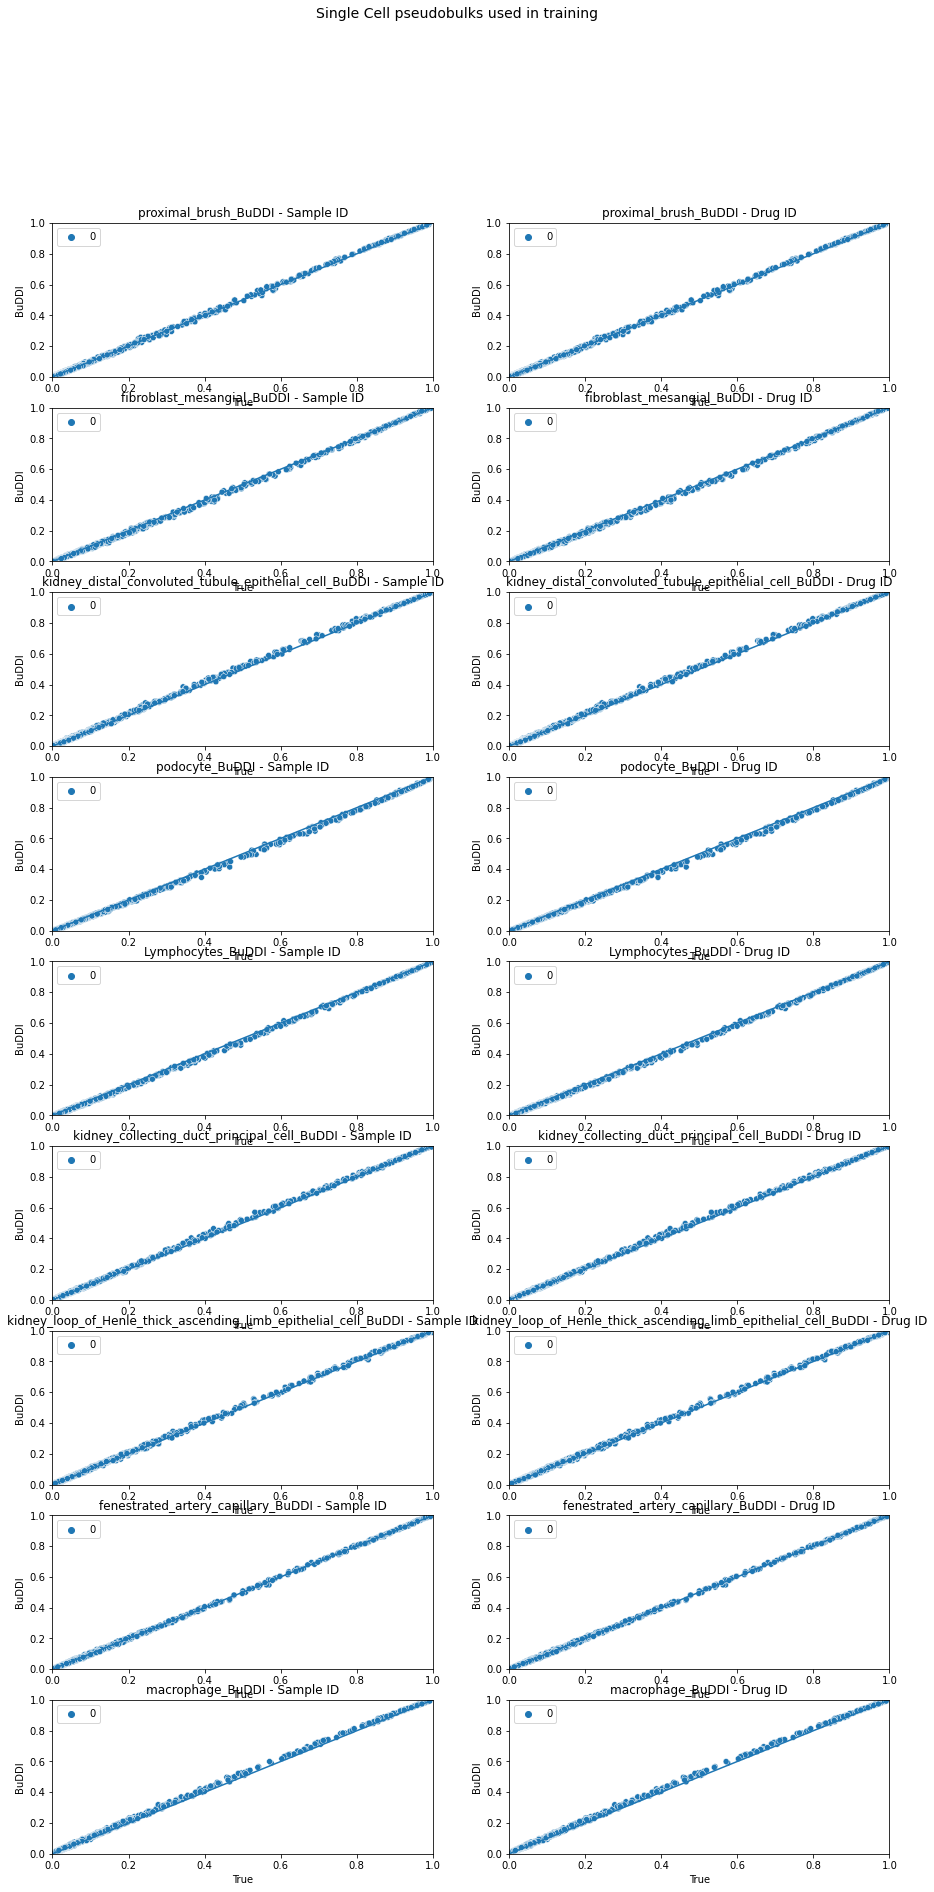

In [64]:
idx_tmp = idx_sc
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

fig, axs = plt.subplots(9, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("Single Cell pseudobulks used in training", fontsize=14)

fig.show()

### compare errors

In [65]:
def read_diva_result_file(res_path, train_id, test_id, unlab_id):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-DIVA.pkl")
    res_path = Path(res_file)
    res_df = pickle.load( open( res_path, "rb" ) )
    return res_df

def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df




In [66]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


def get_errors_single(y_true, y_est):
  mse_err = [mean_sqr_error(y_true, y_est)]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true, y_est)[0]]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true, y_est)[0]]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"] + ["SPR"] + ["PEAR"]

  return plot_df




In [67]:
meta_df

sample_id  stim isTraining      cell_prop_type samp_type  \
0       samp1  CTRL      Train              random    sc_ref   
1       samp1  CTRL      Train              random    sc_ref   
2       samp1  CTRL      Train              random    sc_ref   
3       samp1  CTRL      Train              random    sc_ref   
4       samp1  CTRL      Train              random    sc_ref   
..        ...   ...        ...                 ...       ...   
995     samp3  CTRL       Test  cell_type_specific      bulk   
996     samp3  CTRL       Test  cell_type_specific      bulk   
997     samp3  CTRL       Test  cell_type_specific      bulk   
998     samp3  CTRL       Test  cell_type_specific      bulk   
999     samp3  CTRL       Test  cell_type_specific      bulk   

                                                 Y_max  
0                                           macrophage  
1                         fenestrated_artery_capillary  
2                                       proximal_brush  
3    kidney_loop_of_Henle_thick_ascending_limb_epit...  
4    kidney_loop_of_Henle_thick_ascending_limb_epit...  
..                                                 ...  
995                                         macrophage  
996                                         macrophage  
997                                         macrophage  
998                                         macrophage  
999                                         macrophage  

[5940 rows x 6 columns]

MSqE mean: 0.006488454243726612, median: 0.005916567068225199, max: 0.012924082474634288
Spearman mean: 0.7558333333333334, median: 0.7833333333333333, max: 0.9500000000000001
Pearson mean: 0.9134637741690328, median: 0.9355985236955588, max: 0.9970392180851696
MSqE mean: 0.004810665085040064, median: 0.0038562008847781446, max: 0.01841252116486316
Spearman mean: 0.7366666666666667, median: 0.75, max: 0.9500000000000001
Pearson mean: 0.9071653968554423, median: 0.9446703531938019, max: 0.9918989018489195


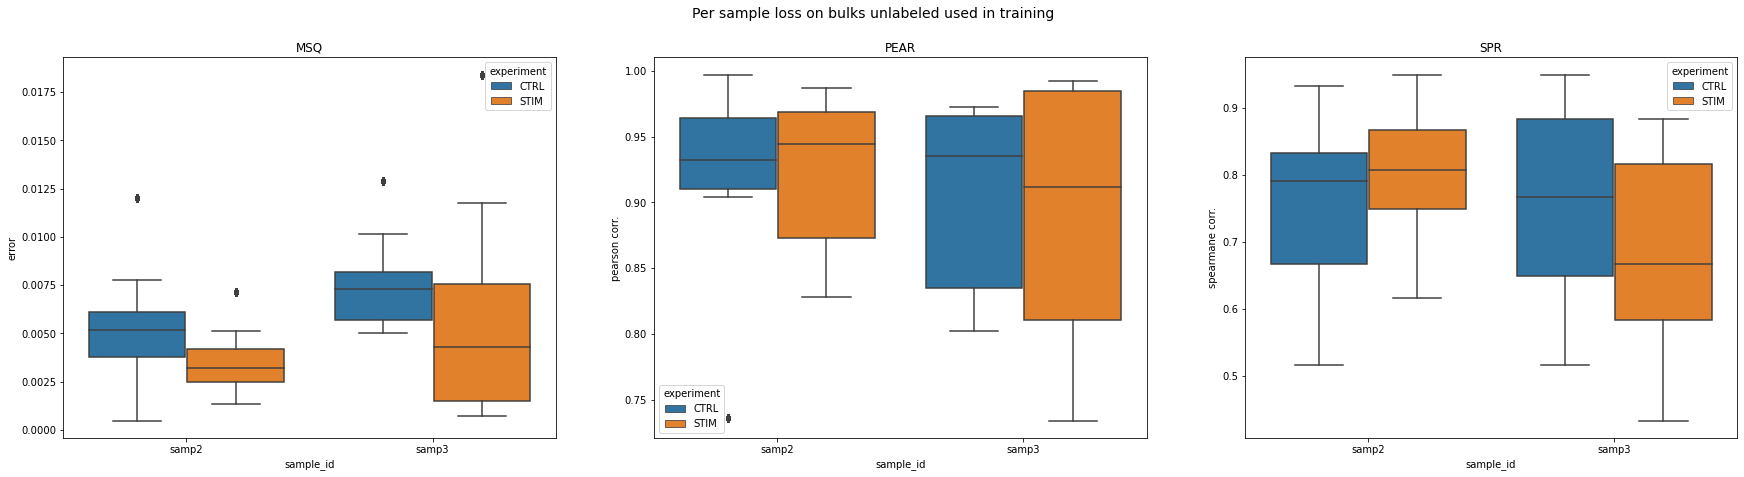

In [68]:
# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "CTRL")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 100)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_ctrl = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_ctrl["experiment"] = ["CTRL"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["method"] = ["BuDDI"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["sample_id"] = np.tile(samp_ids, 3)


# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "STIM")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 100)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_stim = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_stim["experiment"] = ["STIM"]*buddi_err_stim.shape[0]
buddi_err_stim["method"] = ["BuDDI"]*buddi_err_stim.shape[0]
buddi_err_stim["sample_id"] = np.tile(samp_ids, 3)

plot_df = pd.concat([buddi_err_ctrl, buddi_err_stim])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Per sample loss on bulks unlabeled used in training", fontsize=14)

fig.show()

MSqE mean: 0.0038249999144933417, median: 0.0036071570608365304, max: 0.01142341244937419
Spearman mean: 0.7685833333333334, median: 0.7999999999999999, max: 0.9833333333333333
Pearson mean: 0.9532902368910826, median: 0.9561386106642508, max: 0.9998883275413495
MSqE mean: 0.0033790521235727115, median: 0.002873386028411876, max: 0.015673973966294177
Spearman mean: 0.73875, median: 0.7666666666666667, max: 0.9833333333333333
Pearson mean: 0.9475046443221398, median: 0.9543987826794633, max: 0.998647562087124


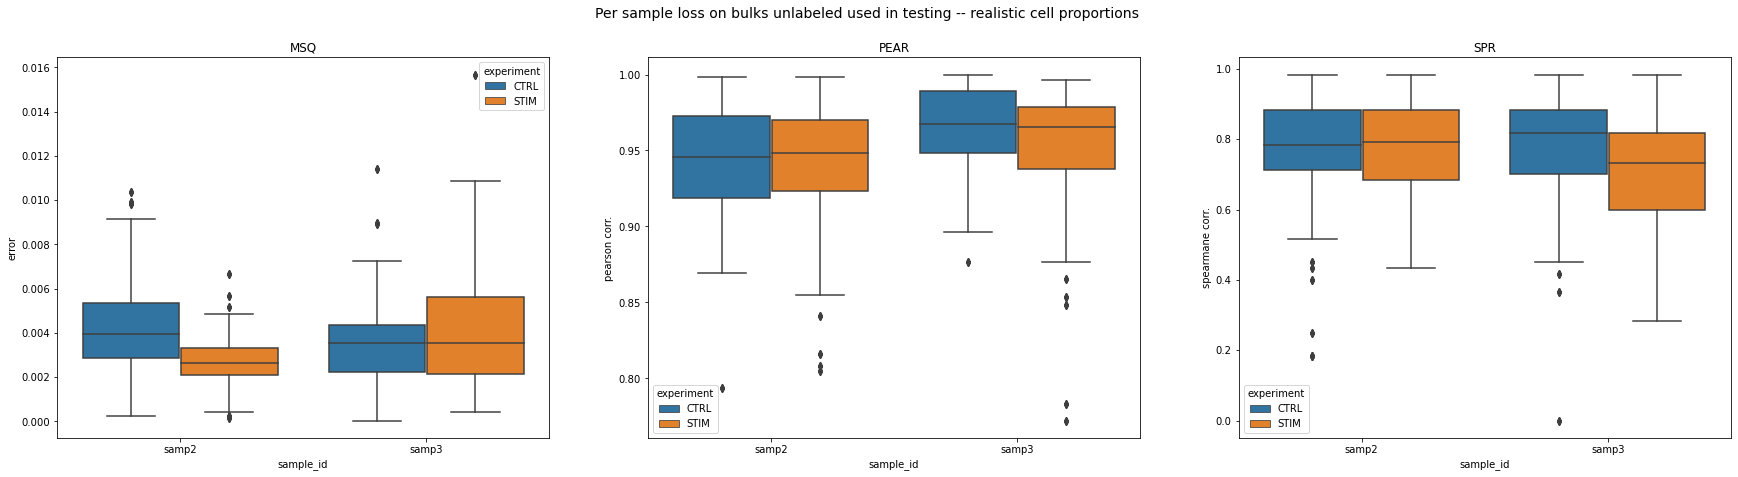

In [69]:
# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "CTRL")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "realistic")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_ctrl = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_ctrl["experiment"] = ["CTRL"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["method"] = ["BuDDI"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["sample_id"] = np.tile(samp_ids, 3)


# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "STIM")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "realistic")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_stim = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_stim["experiment"] = ["STIM"]*buddi_err_stim.shape[0]
buddi_err_stim["method"] = ["BuDDI"]*buddi_err_stim.shape[0]
buddi_err_stim["sample_id"] = np.tile(samp_ids, 3)

plot_df = pd.concat([buddi_err_ctrl, buddi_err_stim])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Per sample loss on bulks unlabeled used in testing -- realistic cell proportions", fontsize=14)

fig.show()

MSqE mean: 0.015803466476613733, median: 0.011365024161757682, max: 0.04386193493687051
Spearman mean: 0.5283888888888888, median: 0.5499999999999999, max: 0.9833333333333333
Pearson mean: 0.9396609038629136, median: 0.9706046192470486, max: 0.9999967564514066
MSqE mean: 0.021194787105814763, median: 0.01710779671267518, max: 0.07319471836242812
Spearman mean: 0.47402777777777777, median: 0.5, max: 1.0
Pearson mean: 0.8898379042065011, median: 0.936471466004815, max: 0.9999927586879064


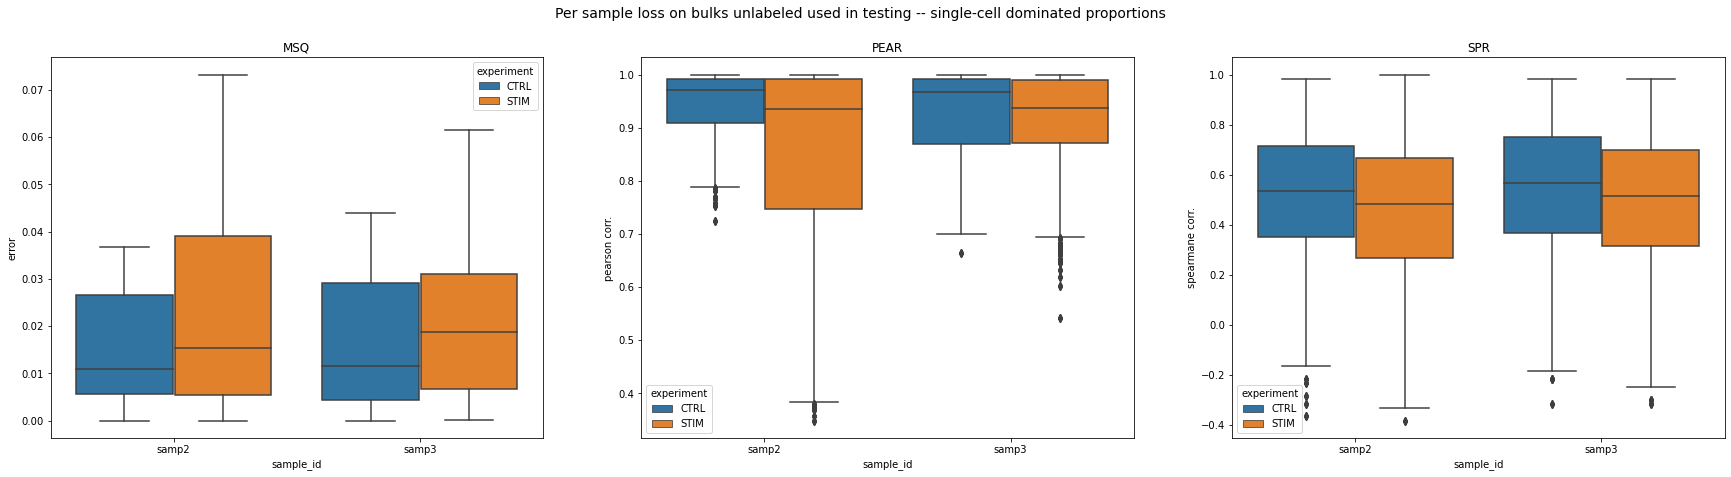

In [70]:
# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "CTRL")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "cell_type_specific")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_ctrl = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_ctrl["experiment"] = ["CTRL"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["method"] = ["BuDDI"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["sample_id"] = np.tile(samp_ids, 3)


# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "STIM")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "cell_type_specific")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_stim = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_stim["experiment"] = ["STIM"]*buddi_err_stim.shape[0]
buddi_err_stim["method"] = ["BuDDI"]*buddi_err_stim.shape[0]
buddi_err_stim["sample_id"] = np.tile(samp_ids, 3)

plot_df = pd.concat([buddi_err_ctrl, buddi_err_stim])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Per sample loss on bulks unlabeled used in testing -- single-cell dominated proportions", fontsize=14)

fig.show()

# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

## Plot Reconstruction

In [71]:
recon_idx = np.logical_and(meta_df.cell_prop_type == "realistic", meta_df.isTraining == "Test")
recon_idx = np.where(recon_idx)[0]




Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)


label_temp = np.copy(Label_full[recon_idx])
perturb_temp = Drug_full[recon_idx]

# need duplicates
len_recon_idx = len(recon_idx)
recon_idx = np.tile(recon_idx, 5)
X_temp = np.copy(X_full[recon_idx])


prop_outputs = classifier.predict(X_temp, batch_size=batch_size)



# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)

decoded_outputs = decoded_outputs[0:len_recon_idx]
X_temp = X_temp[0:len_recon_idx]


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(400, 2)
(400, 2)


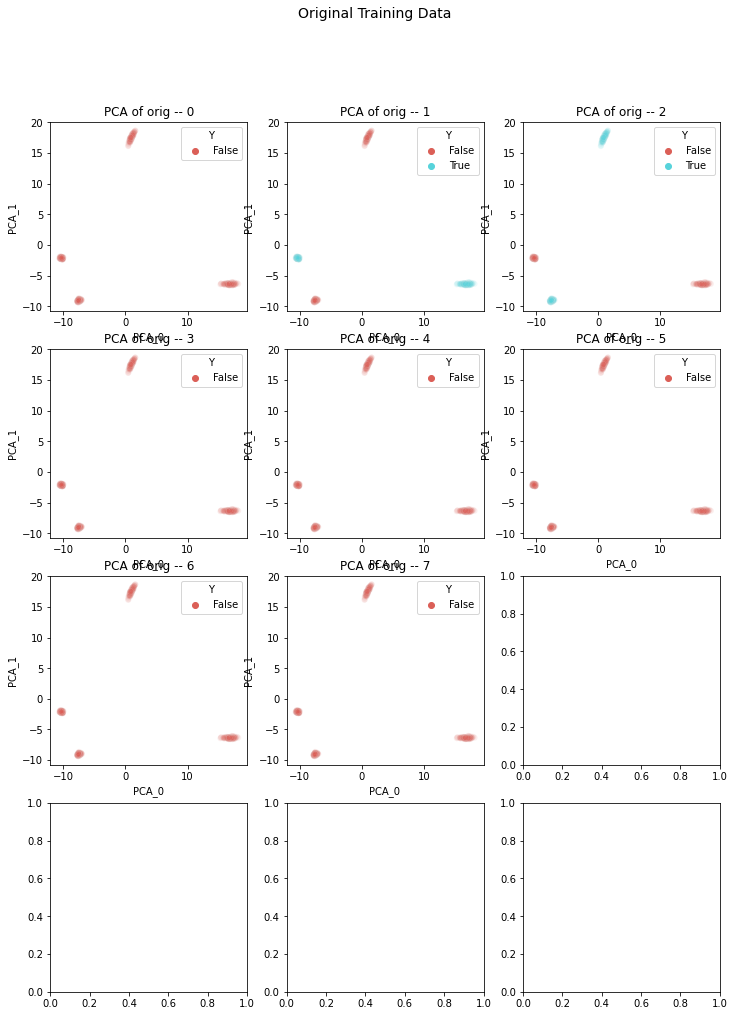

In [72]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = vp.get_pca_for_plotting(np.asarray(X_temp))
vp.plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of orig -- 0")
vp.plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of orig -- 1")
vp.plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of orig -- 2")
vp.plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of orig -- 3")
vp.plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of orig -- 4")
vp.plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of orig -- 5")
vp.plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of orig -- 6")
vp.plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of orig -- 7")


fig.suptitle("Original Training Data", fontsize=14)

fig.show()

(400, 2)
(400, 2)


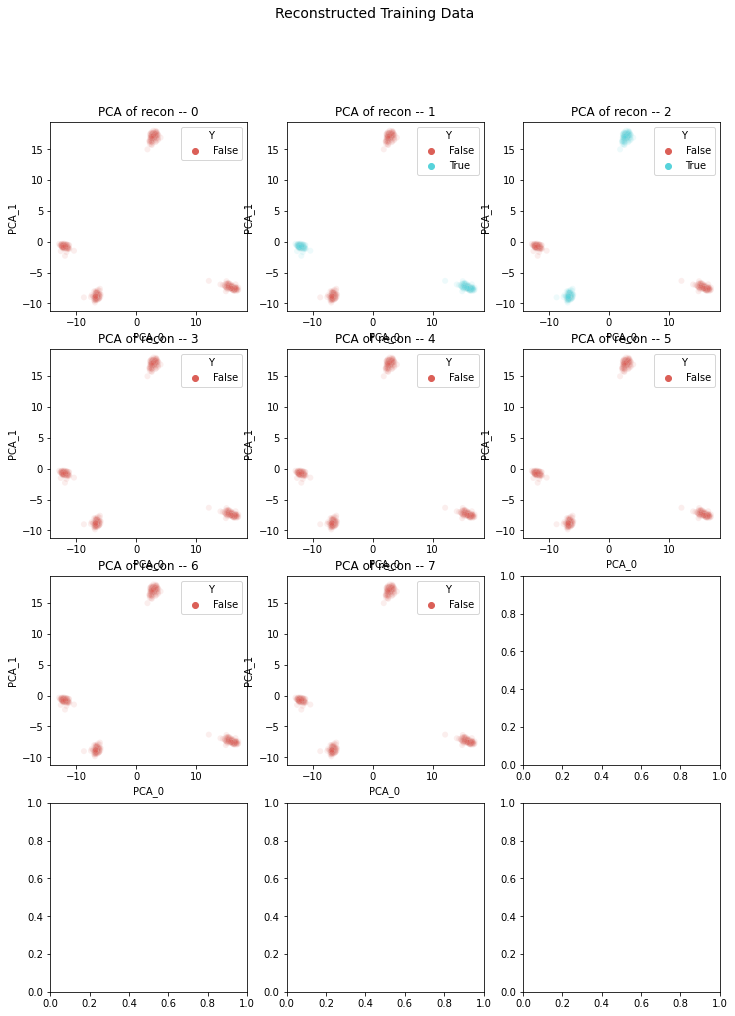

In [73]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = vp.get_pca_for_plotting(np.asarray(decoded_outputs))
vp.plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of recon -- 0")
vp.plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of recon -- 1")
vp.plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of recon -- 2")
vp.plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of recon -- 3")
vp.plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of recon -- 4")
vp.plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of recon -- 5")
vp.plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of recon -- 6")
vp.plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of recon -- 7")


fig.suptitle("Reconstructed Training Data", fontsize=14)

fig.show()

(800, 2)
(800, 2)


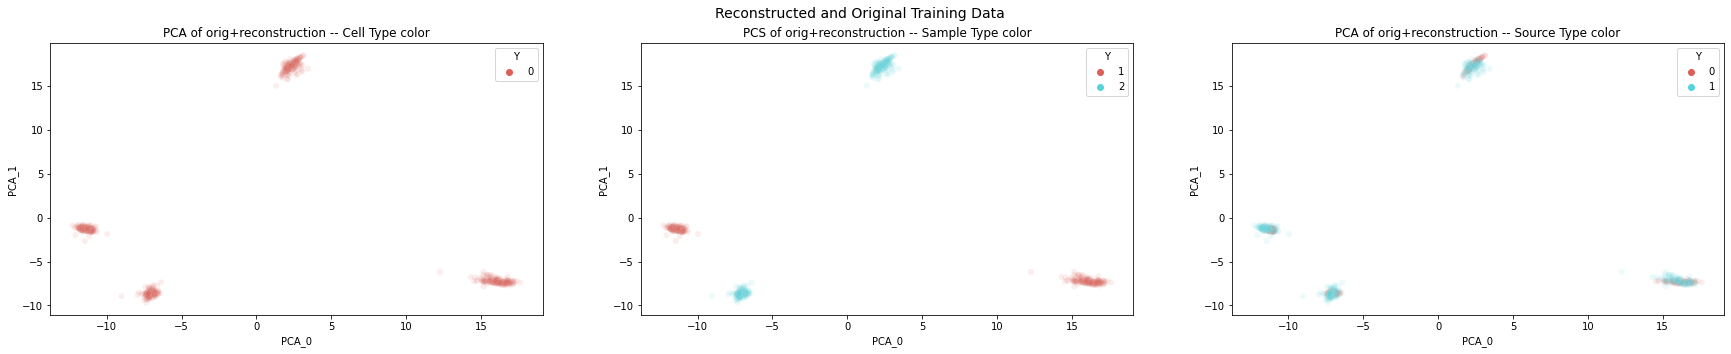

In [75]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])


Y_dup = np.append(Y_temp, Y_temp)

label_dup = np.append(label_temp, label_temp)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*400, [1]*400))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")


fig.suptitle("Reconstructed and Original Training Data", fontsize=14)

fig.show()

### Plot latent spaces

In [76]:
len(idx_train)

1940

Number unique Y: 10
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


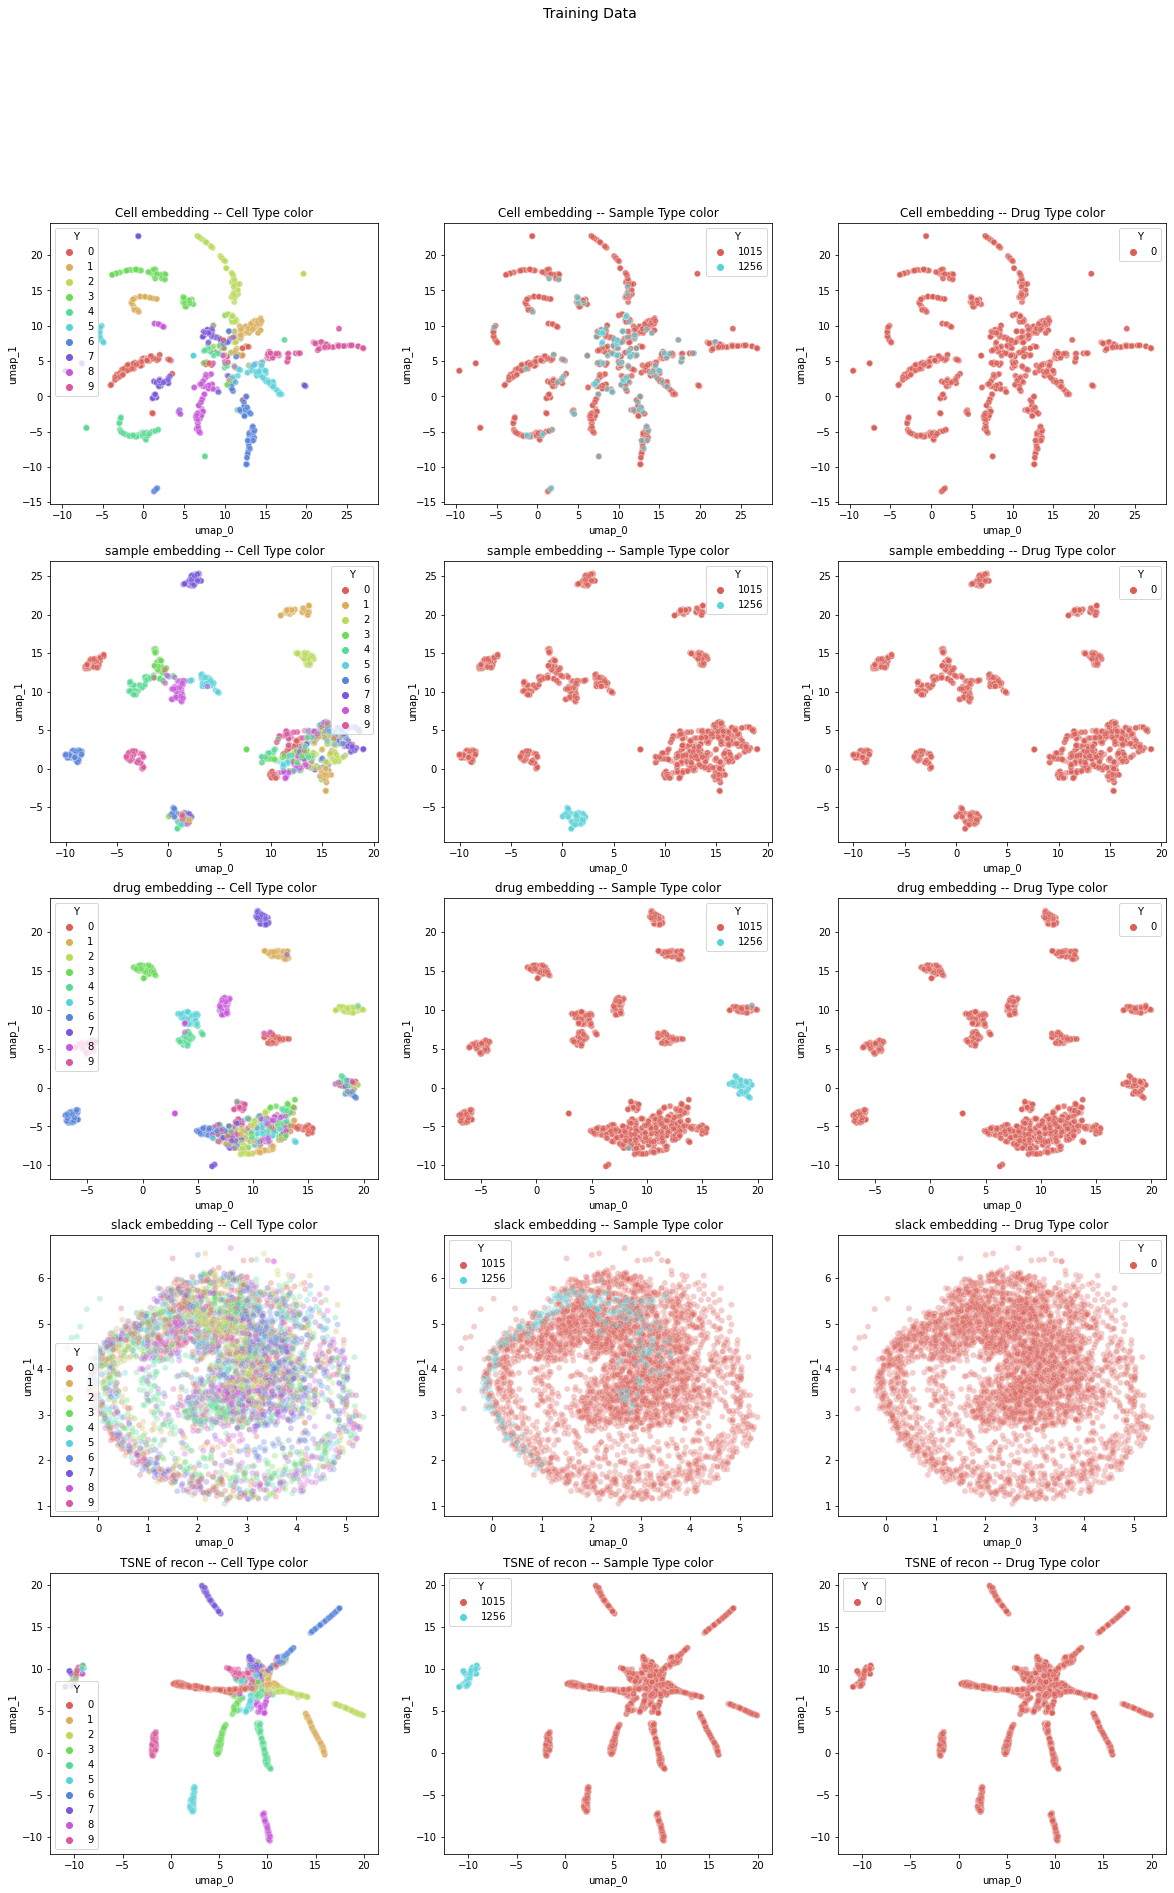

In [55]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

idx_tmp = np.repeat(idx_train, 2)[240:4240]

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)


# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


fig, axs = plt.subplots(5, 3, figsize=(20,30))

plot_df = vp.get_umap_for_plotting(np.asarray(prop_outputs))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(mu_rot))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(mu_drug))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(mu_slack))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[3,0], title="slack embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[3,1], title="slack embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="slack embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(decoded_outputs))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[4,0], title="TSNE of recon -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[4,1], title="TSNE of recon -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[4,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

In [78]:
idx_train = np.where(meta_df.isTraining == "Train")[0]
idx_train.shape[0]

1940

Number unique Y: 9
(1940, 2)
(1940, 2)
(1940, 2)
(1940, 2)
(1940, 2)
(1940, 2)


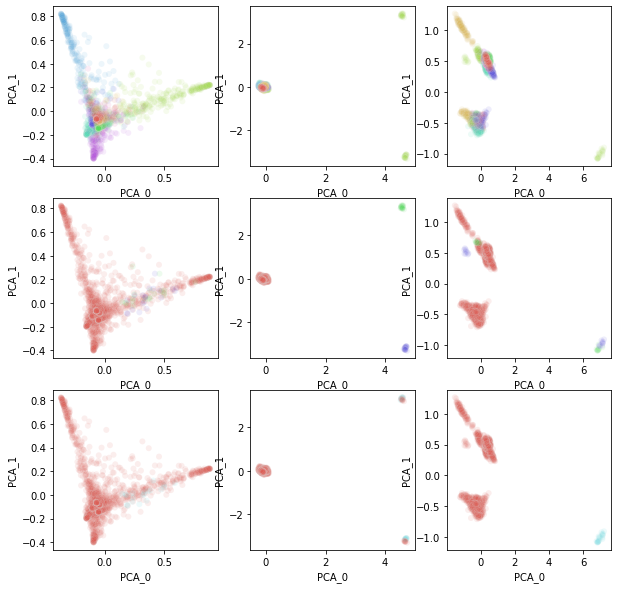

In [81]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_tmp = np.where(meta_df.isTraining == "Train")[0]
len_idx = idx_tmp.shape[0]
idx_tmp = np.tile(idx_tmp, 25)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = true_prop_df.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, _, _, z_rot, mu_rot, _, z_drug, mu_drug, _ = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)

z_slack = z_slack[0:len_idx]
z_rot = z_rot[0:len_idx]
mu_rot = mu_rot[0:len_idx]
z_drug = z_drug[0:len_idx]
mu_drug = mu_drug[0:len_idx]
prop_outputs = prop_outputs[0:len_idx]
decoded_outputs = decoded_outputs[0:len_idx]

Y_temp = Y_temp[0:len_idx]
label_temp = label_temp[0:len_idx]
perturb_temp = perturb_temp[0:len_idx]


fig, axs = plt.subplots(3, 3, figsize=(10,10))

plot_df = vp.get_pca_for_plotting(np.asarray(prop_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,0], title="")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[1,0], title="")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2,0], title="")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_rot))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,1], title="")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[1,1], title="")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2,1], title="")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_drug))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,2], title="")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[1,2], title="")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="")


#fig.suptitle("Training Data", fontsize=14)

fig.show()

out_plot = os.path.join(res_data_path, f"output1.pdf")
fig.savefig(out_plot, dpi=300)

for ax1 in axs:
    for ax2 in ax1:
        ax2.get_legend().remove()

    
out_plot = os.path.join(res_data_path, f"output2.pdf")
fig.savefig(out_plot, dpi=300)

In [101]:
idx_tmp = np.where(meta_df.isTraining=="Test")[0]
meta_df.iloc[idx_tmp].cell_prop_type.value_counts()

cell_type_specific    3600
realistic              400
Name: cell_prop_type, dtype: int64

In [117]:
# test values
idx_tmp = np.where(meta_df.isTraining == "Test")[0]
len_tmp = len(idx_tmp)
idx_tmp = np.tile(idx_tmp, 5)


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)

# get back the unrepeated index
idx_tmp = idx_tmp[0:len_tmp]
prop_outputs = prop_outputs[0:len_tmp]
mu_rot = mu_rot[0:len_tmp]
mu_drug = mu_drug[0:len_tmp]


# get the other labels of interest

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
# make 1-hot
Y_temp_1hot = np.zeros((Y_temp.size, Y_temp.max() + 1))
Y_temp_1hot[np.arange(Y_temp.size), Y_temp] = 1

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
# make 1-hot
label_temp_1hot = np.zeros((label_temp.size, label_temp.max() + 1))
label_temp_1hot[np.arange(label_temp.size), label_temp] = 1


perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]
# make 1-hot
perturb_temp_1hot = np.zeros((perturb_temp.size, perturb_temp.max() + 1))
perturb_temp_1hot[np.arange(perturb_temp.size), perturb_temp] = 1


In [118]:
# NOW predict most abundant cell type
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit

def run_RF(X_in, Y_in):

    sss = StratifiedShuffleSplit(n_splits=2, test_size=100, random_state=0)
    _, index = sss.split(X_in, Y_in)
    x_rf_train, y_rf_train = X_in[index[1]], Y_in[index[1]]
    x_rf_test, y_rf_test = X_in[index[0]], Y_in[index[0]]

    clf = RandomForestClassifier(random_state=0)
    clf.fit(x_rf_train, y_rf_train)
    y_rf_pred = clf.predict(x_rf_test)
    out_f1 = np.median(f1_score(y_rf_test, y_rf_pred, average=None))

    return out_f1

########
## using prop_outputs
########

prop_y_f1 = run_RF(prop_outputs, Y_temp_1hot)
prop_lab_f1 = run_RF(prop_outputs, label_temp_1hot)
prop_pert_f1 = run_RF(prop_outputs, perturb_temp_1hot)

########
## using mu_rot
########

samp_y_f1 = run_RF(mu_rot, Y_temp_1hot)
samp_lab_f1 = run_RF(mu_rot, label_temp_1hot)
samp_pert_f1 = run_RF(mu_rot, perturb_temp_1hot)


########
## using mu_drug
########

drug_y_f1 = run_RF(mu_drug, Y_temp_1hot)
drug_lab_f1 = run_RF(mu_drug, label_temp_1hot)
drug_pert_f1 = run_RF(mu_drug, perturb_temp_1hot)



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this

In [119]:
print(f"{prop_y_f1}, {prop_lab_f1}, {prop_pert_f1}")
print(f"{samp_y_f1}, {samp_lab_f1}, {samp_pert_f1}")
print(f"{drug_y_f1}, {drug_lab_f1}, {drug_pert_f1}")

0.9870129870129869, 0.6560846560846562, 0.8536571007723034
0.6712095400340715, 1.0, 0.9623830008134946
0.806697108066971, 0.9662802950474182, 1.0


In [98]:
meta_df.iloc[np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type != "cell_type_specific"))[0]]

sample_id  stim isTraining cell_prop_type samp_type  \
0      samp1  CTRL      Train         random    sc_ref   
1      samp1  CTRL      Train         random    sc_ref   
2      samp1  CTRL      Train         random    sc_ref   
3      samp1  CTRL      Train         random    sc_ref   
4      samp1  CTRL      Train         random    sc_ref   
..       ...   ...        ...            ...       ...   
22     samp3  CTRL      Train      realistic      bulk   
25     samp3  CTRL      Train      realistic      bulk   
27     samp3  CTRL      Train      realistic      bulk   
51     samp3  CTRL      Train      realistic      bulk   
29     samp3  CTRL      Train      realistic      bulk   

                                                Y_max  
0                                          macrophage  
1                        fenestrated_artery_capillary  
2                                      proximal_brush  
3   kidney_loop_of_Henle_thick_ascending_limb_epit...  
4   kidney_loop_of_Henle_thick_ascending_limb_epit...  
..                                                ...  
22                                     proximal_brush  
25                                     proximal_brush  
27                                     proximal_brush  
51                                     proximal_brush  
29                                     proximal_brush  

[1040 rows x 6 columns]

Number unique Y: 9
(1040, 2)
(1040, 2)
(1040, 2)
(1040, 2)
(1040, 2)
(1040, 2)
(1040, 2)
(1040, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: divide by zero encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


(1040, 2)
(1040, 2)


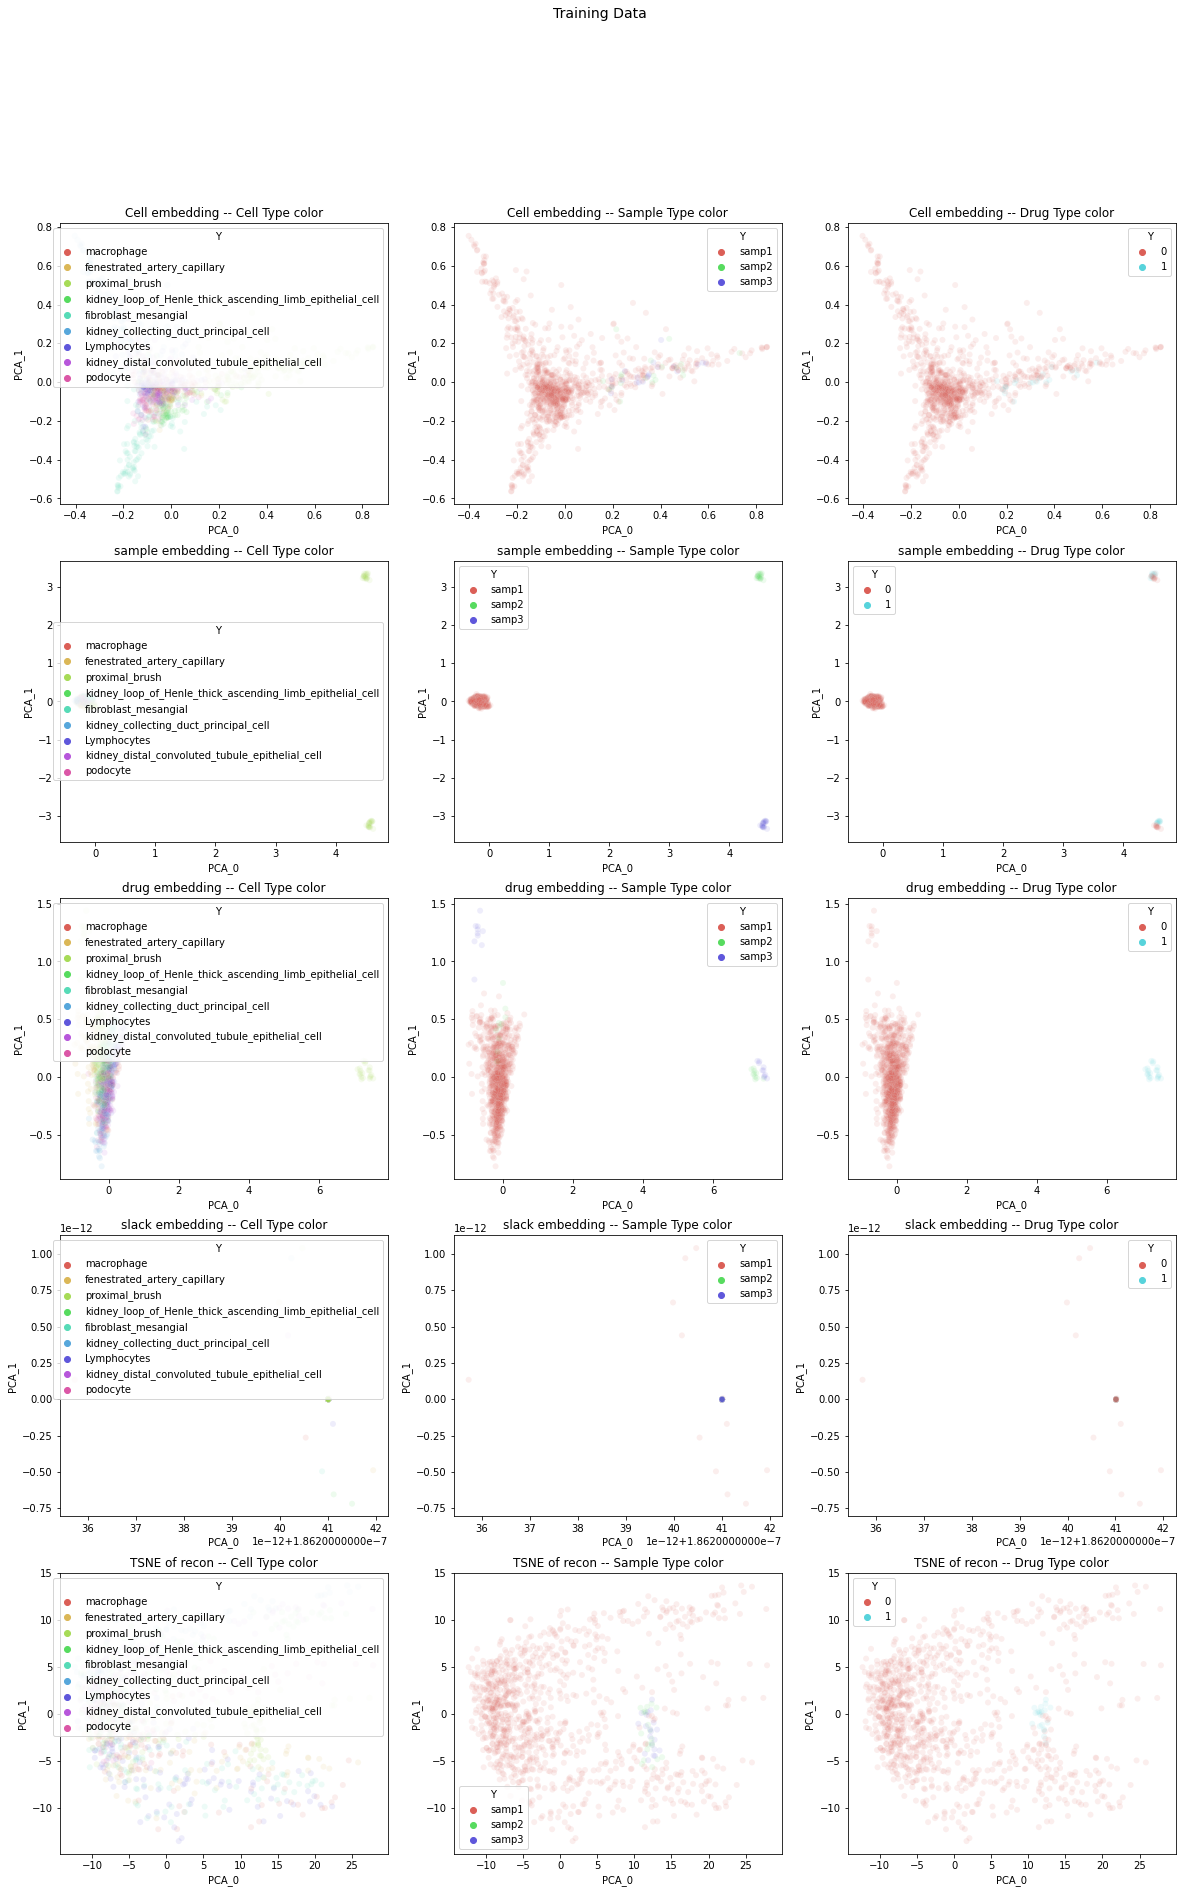

In [99]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type != "cell_type_specific"))[0]
len_idx = idx_tmp.shape[0]
idx_tmp = np.tile(idx_tmp, 25)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = true_prop_df.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, _, z_rot, mu_rot, _, z_drug, mu_drug, _ = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)

z_slack = z_slack[0:len_idx]
mu_slack = mu_slack[0:len_idx]
z_rot = z_rot[0:len_idx]
mu_rot = mu_rot[0:len_idx]
z_drug = z_drug[0:len_idx]
mu_drug = mu_drug[0:len_idx]
prop_outputs = prop_outputs[0:len_idx]
decoded_outputs = decoded_outputs[0:len_idx]

Y_temp = Y_temp[0:len_idx]
label_temp = label_temp[0:len_idx]
perturb_temp = perturb_temp[0:len_idx]

fig, axs = plt.subplots(5, 3, figsize=(20,30))

plot_df = vp.get_pca_for_plotting(np.asarray(prop_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_rot))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_drug))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_slack))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[3,0], title="slack embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[3,1], title="slack embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="slack embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(decoded_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[4,0], title="TSNE of recon -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[4,1], title="TSNE of recon -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[4,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

## Do latent space projectsions

### drug perturbation

In [120]:
sample_interest = ['samp1', 'samp2', 'samp3']
sample_code_idx = np.logical_and(meta_df.isTraining == "Train", 
                                    np.isin(meta_df.sample_id, sample_interest))
sample_code_idx = np.logical_and(sample_code_idx, meta_df.stim == "STIM")
sample_code_idx = np.where(sample_code_idx)[0] 
sample_code_idx = np.repeat(sample_code_idx, 200)
a = meta_df.iloc[sample_code_idx]
a.sample_id.value_counts()

samp2    2000
samp3    2000
Name: sample_id, dtype: int64

In [138]:
sample_interest = ['samp2', 'samp3']
sample_code_idx = np.logical_and(meta_df.isTraining == "Train", 
                                    np.isin(meta_df.sample_id, sample_interest))
sample_code_idx = np.logical_and(sample_code_idx, meta_df.stim == "CTRL")
sample_code_idx = np.where(sample_code_idx)[0]
len(sample_code_idx)

20

In [139]:

# get the training data
# so we can use it to get the latent codes
idx_train = np.where(meta_df.isTraining == "Train")[0]
train_meta_df = meta_df.iloc[idx_train]

X_temp = np.copy(X_full)

#####
# get cell type latent codes
#####
# the the codes for cell type proportion
sc_props = sc_preprocess.get_single_celltype_prop_matrix(num_samp=200, cell_order=Y_full.columns)
sc_props = np.tile(sc_props, (5,1))


#####
# get perturbation latent codes
#####

# get the index to get the perturbation latent codes
pert_code_idx = np.logical_and(meta_df.isTraining == "Train", meta_df.stim == "STIM")
pert_code_idx = np.where(pert_code_idx)[0] 
pert_code_idx = np.random.choice(pert_code_idx, 9000, replace=True)
z_slack, _, _, z_rot, _, _, z_pert, _, _ = encoder_unlab.predict(X_temp[pert_code_idx,], batch_size=batch_size)


# get the index to get the UNperturbed latent codes
unpert_code_idx = np.logical_and(meta_df.isTraining == "Train", meta_df.stim == "CTRL")
unpert_code_idx = np.where(unpert_code_idx)[0] 
unpert_code_idx = np.random.choice(unpert_code_idx, 9000, replace=True)
z_slack, _, _, z_rot, _, _, z_unpert, _, _ = encoder_unlab.predict(X_temp[unpert_code_idx,], batch_size=batch_size)

#####
# get sample latent codes
#####
# get the index to get the sample latent codes
sample_interest = ['samp2', 'samp3']
sample_code_idx = np.logical_and(meta_df.isTraining == "Train", 
                                    np.isin(meta_df.sample_id, sample_interest))
sample_code_idx = np.logical_and(sample_code_idx, meta_df.stim == "CTRL")
sample_code_idx = np.where(sample_code_idx)[0] 
sample_code_idx = np.repeat(sample_code_idx, 450)

z_slack, _, _, z_samples, _, _, z_drug, _, _ = encoder_unlab.predict(X_temp[sample_code_idx,], batch_size=batch_size)


# make the metadata table 
temp_meta_df = meta_df.iloc[sample_code_idx]
temp_meta_df.isTraining = "Test"
temp_meta_df.cell_prop_type = "cell_type_specific"

prop_max = np.copy(sc_props)
prop_max = np.argmax(prop_max, axis=1)
prop_max = Y_full.columns[prop_max]
temp_meta_df.Y_max = prop_max

######
# now put it all together
######

# now concatenate together and add the stim codes to the latent
z_concat_unlab_perturb = np.hstack([z_slack, sc_props, z_samples, z_pert])
decoded_0_1 = decoder.predict(z_concat_unlab_perturb, batch_size=batch_size)
decoded_0_1 = scaler.inverse_transform(decoded_0_1)

# now concatenate together and add the stim codes to the latent
z_concat_unlab_perturb = np.hstack([z_slack, sc_props, z_samples, z_pert])
decoded_0_0 = decoder.predict(z_concat_unlab_perturb, batch_size=batch_size)
decoded_0_0 = scaler.inverse_transform(decoded_0_0)





<ipython-input-139-009bd6c0a359>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.isTraining = "Test"
<ipython-input-139-009bd6c0a359>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.cell_prop_type = "cell_type_specific"
<ipython-input-139-009bd6c0a359>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [142]:

def calc_buddi_perturbation(meta_df, X_full, scaler, encoder_unlab, decoder, batch_size):

    # get the training data
    # so we can use it to get the latent codes
    idx_train = np.where(meta_df.isTraining == "Train")[0]
    train_meta_df = meta_df.iloc[idx_train]

    X_temp = np.copy(X_full)

    #####
    # get cell type latent codes
    #####
    # the the codes for cell type proportion
    sc_props = sc_preprocess.get_single_celltype_prop_matrix(num_samp=200, cell_order=Y_full.columns)
    sc_props = np.tile(sc_props, (5,1))


    #####
    # get perturbation latent codes
    #####

    # get the index to get the perturbation latent codes
    pert_code_idx = np.logical_and(meta_df.isTraining == "Train", meta_df.stim == "STIM")
    pert_code_idx = np.where(pert_code_idx)[0] 
    pert_code_idx = np.random.choice(pert_code_idx, 9000, replace=True)
    z_slack, _, _, z_rot, _, _, z_pert, _, _ = encoder_unlab.predict(X_temp[pert_code_idx,], batch_size=batch_size)


    # get the index to get the UNperturbed latent codes
    unpert_code_idx = np.logical_and(meta_df.isTraining == "Train", meta_df.stim == "CTRL")
    unpert_code_idx = np.where(unpert_code_idx)[0] 
    unpert_code_idx = np.random.choice(unpert_code_idx, 9000, replace=True)
    z_slack, _, _, z_rot, _, _, z_unpert, _, _ = encoder_unlab.predict(X_temp[unpert_code_idx,], batch_size=batch_size)

    #####
    # get sample latent codes
    #####
    # get the index to get the sample latent codes
    sample_interest = ['samp2', 'samp3']
    sample_code_idx = np.logical_and(meta_df.isTraining == "Train", 
                                        np.isin(meta_df.sample_id, sample_interest))
    sample_code_idx = np.logical_and(sample_code_idx, meta_df.stim == "CTRL")
    sample_code_idx = np.where(sample_code_idx)[0] 
    sample_code_idx = np.repeat(sample_code_idx, 450)

    z_slack, _, _, z_samples, _, _, z_drug, _, _ = encoder_unlab.predict(X_temp[sample_code_idx,], batch_size=batch_size)


    # make the metadata table 
    temp_meta_df = meta_df.iloc[sample_code_idx]
    temp_meta_df.isTraining = "Test"
    temp_meta_df.cell_prop_type = "cell_type_specific"

    prop_max = np.copy(sc_props)
    prop_max = np.argmax(prop_max, axis=1)
    prop_max = Y_full.columns[prop_max]
    temp_meta_df.Y_max = prop_max

    ######
    # now put it all together
    ######

    # now concatenate together and add the stim codes to the latent
    z_concat_perturb = np.hstack([z_slack, sc_props, z_samples, z_pert])
    decoded_0_1 = decoder.predict(z_concat_perturb, batch_size=batch_size)
    decoded_0_1 = scaler.inverse_transform(decoded_0_1)

    # now concatenate together and add the stim codes to the latent
    z_concat_unperturb = np.hstack([z_slack, sc_props, z_samples, z_unpert])
    decoded_0_0 = decoder.predict(z_concat_unperturb, batch_size=batch_size)
    decoded_0_0 = scaler.inverse_transform(decoded_0_0)




    return (temp_meta_df, decoded_0_0, decoded_0_1)


In [143]:
stim_test_meta_df, decoded_0_0, decoded_0_1 = calc_buddi_perturbation(meta_df, X_full, scaler, encoder_unlab, decoder, batch_size)


<ipython-input-142-6872fe061f5e>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.isTraining = "Test"
<ipython-input-142-6872fe061f5e>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.cell_prop_type = "cell_type_specific"
<ipython-input-142-6872fe061f5e>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [144]:
decoded_0_0.shape

(9000, 7000)

In [145]:
stim_test_meta_df

sample_id  stim isTraining      cell_prop_type samp_type           Y_max
65     samp2  CTRL       Test  cell_type_specific      bulk  proximal_brush
65     samp2  CTRL       Test  cell_type_specific      bulk  proximal_brush
65     samp2  CTRL       Test  cell_type_specific      bulk  proximal_brush
65     samp2  CTRL       Test  cell_type_specific      bulk  proximal_brush
65     samp2  CTRL       Test  cell_type_specific      bulk  proximal_brush
..       ...   ...        ...                 ...       ...             ...
29     samp3  CTRL       Test  cell_type_specific      bulk      macrophage
29     samp3  CTRL       Test  cell_type_specific      bulk      macrophage
29     samp3  CTRL       Test  cell_type_specific      bulk      macrophage
29     samp3  CTRL       Test  cell_type_specific      bulk      macrophage
29     samp3  CTRL       Test  cell_type_specific      bulk      macrophage

[9000 rows x 6 columns]

In [146]:
real_ctrl_idx = np.logical_and(meta_df.stim == "CTRL", meta_df.isTraining == "Test")
real_ctrl_idx = np.logical_and(real_ctrl_idx, meta_df.cell_prop_type == "cell_type_specific")
real_ctrl_idx = np.logical_and(real_ctrl_idx, meta_df.sample_id == "samp2")
real_ctrl_idx = np.logical_and(real_ctrl_idx, meta_df.Y_max == "macrophage")
real_ctrl_idx = np.where(real_ctrl_idx)[0]
len(real_ctrl_idx)

100

In [147]:
real_ctrl_idx = np.logical_and(stim_test_meta_df.stim == "CTRL", stim_test_meta_df.isTraining == "Test")
real_ctrl_idx = np.logical_and(real_ctrl_idx, stim_test_meta_df.cell_prop_type == "cell_type_specific")
real_ctrl_idx = np.logical_and(real_ctrl_idx, stim_test_meta_df.sample_id == "samp2")
real_ctrl_idx = np.logical_and(real_ctrl_idx, stim_test_meta_df.Y_max == "macrophage")
real_ctrl_idx = np.where(real_ctrl_idx)[0]
len(real_ctrl_idx)

400

In [148]:

# run first the cell_type specific things

cell_type_specific_r2 = None
cell_type_specific_real = None
cell_type_specific_proj = None
meta_DESeq = None
all_samps = ['samp2', 'samp3']

ctrl_test_meta_df, decoded_0_0, decoded_0_1 = calc_buddi_perturbation(meta_df, X_full, scaler, encoder_unlab, decoder, batch_size)


for curr_samp in all_samps:
    print(curr_samp)
    for curr_cell_type in Y_full.columns:
        print(curr_cell_type)

        real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full, decoded_0_0, 
                                                                                        decoded_0_1, scaler, curr_samp, 
                                                                                        "cell_type_specific", 
                                                                                        meta_df, ctrl_test_meta_df,
                                                                                        curr_cell_type)

        expr_r2, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse = vp.calc_expr_log2FC_r2(real_ctrl, real_stim, proj_ctrl, proj_stim)

        curr_res = [curr_samp, curr_cell_type, "cell_type_specific", expr_r2, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse]
        curr_res = pd.DataFrame([curr_res],  columns = ['sample_id', 'cell_type', 'bulk_type', 
                                                        'expr_r2', 'log2FC_r2',
                                                        'log2FC_r2_bottom', 'log2FC_r2_mid', 'log2FC_r2_top', 'log2FC_rmse'])

        curr_meta = {'sample_id':[curr_samp]*(proj_stim.shape[0]*2),
                     'cell_type':[curr_cell_type]*(proj_stim.shape[0]*2),
                     'cond':['ctrl']*(proj_stim.shape[0]) + ['stim']*(proj_stim.shape[0])}
        curr_meta = pd.DataFrame(curr_meta)
        curr_DESeq_real = np.append(real_ctrl, real_stim, axis=0)
        curr_DESeq_proj = np.append(proj_ctrl, proj_stim, axis=0)

        if cell_type_specific_r2 is None:
            cell_type_specific_r2 = curr_res
            meta_DESeq = curr_meta
            cell_type_specific_real = curr_DESeq_real
            cell_type_specific_proj = curr_DESeq_proj
        else:
             cell_type_specific_r2 = pd.concat([cell_type_specific_r2, curr_res])
             meta_DESeq = pd.concat([meta_DESeq, curr_meta])
             cell_type_specific_real = np.append(cell_type_specific_real, curr_DESeq_real, axis=0)
             cell_type_specific_proj = np.append(cell_type_specific_proj, curr_DESeq_proj, axis=0)



# now run the realistic ones

<ipython-input-142-6872fe061f5e>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.isTraining = "Test"
<ipython-input-142-6872fe061f5e>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.cell_prop_type = "cell_type_specific"
<ipython-input-142-6872fe061f5e>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

samp2
proximal_brush
fibroblast_mesangial
kidney_distal_convoluted_tubule_epithelial_cell
podocyte
Lymphocytes
kidney_collecting_duct_principal_cell
kidney_loop_of_Henle_thick_ascending_limb_epithelial_cell
fenestrated_artery_capillary
macrophage
samp3
proximal_brush
fibroblast_mesangial
kidney_distal_convoluted_tubule_epithelial_cell
podocyte
Lymphocytes
kidney_collecting_duct_principal_cell
kidney_loop_of_Henle_thick_ascending_limb_epithelial_cell
fenestrated_artery_capillary
macrophage


In [149]:
cell_type_specific_r2

sample_id                                          cell_type  \
0     samp2                                     proximal_brush   
0     samp2                               fibroblast_mesangial   
0     samp2    kidney_distal_convoluted_tubule_epithelial_cell   
0     samp2                                           podocyte   
0     samp2                                        Lymphocytes   
0     samp2              kidney_collecting_duct_principal_cell   
0     samp2  kidney_loop_of_Henle_thick_ascending_limb_epit...   
0     samp2                       fenestrated_artery_capillary   
0     samp2                                         macrophage   
0     samp3                                     proximal_brush   
0     samp3                               fibroblast_mesangial   
0     samp3    kidney_distal_convoluted_tubule_epithelial_cell   
0     samp3                                           podocyte   
0     samp3                                        Lymphocytes   
0     samp3              kidney_collecting_duct_principal_cell   
0     samp3  kidney_loop_of_Henle_thick_ascending_limb_epit...   
0     samp3                       fenestrated_artery_capillary   
0     samp3                                         macrophage   

            bulk_type   expr_r2  log2FC_r2  log2FC_r2_bottom  log2FC_r2_mid  \
0  cell_type_specific  0.972728   0.783570          0.658242       0.883433   
0  cell_type_specific  0.723056   0.594785          0.558775       0.571290   
0  cell_type_specific  0.771428   0.595829          0.568745       0.589211   
0  cell_type_specific  0.782818   0.612301          0.532682       0.633235   
0  cell_type_specific  0.566924   0.598795          0.537265       0.571090   
0  cell_type_specific  0.762720   0.638487          0.579529       0.700900   
0  cell_type_specific  0.886185   0.679260          0.571400       0.758628   
0  cell_type_specific  0.848568   0.701370          0.606617       0.746449   
0  cell_type_specific  0.683578   0.629726          0.551893       0.615379   
0  cell_type_specific  0.970289   0.787309          0.664732       0.902335   
0  cell_type_specific  0.750001   0.563342          0.529758       0.533516   
0  cell_type_specific  0.721777   0.561097          0.481146       0.568565   
0  cell_type_specific  0.785557   0.550608          0.442583       0.565051   
0  cell_type_specific  0.620986   0.611537          0.521361       0.606276   
0  cell_type_specific  0.739286   0.587396          0.487161       0.669737   
0  cell_type_specific  0.886534   0.618637          0.536517       0.664869   
0  cell_type_specific  0.819295   0.673764          0.552734       0.720885   
0  cell_type_specific  0.705285   0.595170          0.524331       0.590602   

   log2FC_r2_top  log2FC_rmse  
0       0.943872     1.582769  
0       0.573358     2.836092  
0       0.651143     2.360764  
0       0.716521     2.451574  
0       0.564679     2.514258  
0       0.696041     2.264067  
0       0.818883     2.132405  
0       0.810287     2.123981  
0       0.653058     2.328568  
0       0.957094     1.652108  
0       0.559658     2.943415  
0       0.634892     2.665903  
0       0.678690     2.646655  
0       0.595033     2.487394  
0       0.638818     2.347642  
0       0.669235     2.448732  
0       0.770912     2.046892  
0       0.607110     2.432596

In [150]:
pearson_res_file = os.path.join(res_data_path, f"{exp_id}_pearson_matr.csv")
cell_type_specific_r2.to_csv(pearson_res_file, index=False)


# Diff Expr

In [ ]:
def get_cell_type_DE(meta_DESeq, de_proj, de_real, cell_type_interest, TP_max=3, TN_min=1.25):
    # get the index of the cell type of interest
    cell_idx = np.where(meta_DESeq.cell_type == cell_type_interest)[0]
    de_proj_cell = de_proj.iloc[cell_idx,]
    de_real_cell = de_real.iloc[cell_idx,]
    meta_DESeq_cell = meta_DESeq.iloc[cell_idx,]

    # reindex so that anndata obj can be created easily
    new_index = ["samp_" + str(s) for s in range(len(cell_idx))]
    de_proj_cell.index = new_index
    meta_DESeq_cell.index = new_index
    de_real_cell.index = new_index

    # run deseq for projection
    dds_proj_cell = DeseqDataSet(
        counts=de_proj_cell,
        clinical=meta_DESeq_cell,
        design_factors=["cond", "sample_id"],
        refit_cooks=True
    )

    dds_proj_cell.deseq2()
    cell_proj_res = DeseqStats(dds_proj_cell, contrast=["cond", "ctrl", "stim"])
    cell_proj_res.summary()

    # run deseq for real data
    dds_real_cell = DeseqDataSet(
        counts=de_real_cell,
        clinical=meta_DESeq_cell,
        design_factors=["cond", "sample_id"],
        refit_cooks=True
    )

    dds_real_cell.deseq2()
    cell_real_res = DeseqStats(dds_real_cell, contrast=["cond", "ctrl", "stim"])
    cell_real_res.summary()

    # now get the TP and TN

    # get the DESeq res matrix
    cell_real_res_df = cell_real_res.results_df
    cell_proj_res_df = cell_proj_res.results_df


    # get the "true positives"
    real_TP = cell_real_res_df.iloc[np.where(np.abs(cell_real_res_df.log2FoldChange) > TP_max)[0]]
    real_TP_list = real_TP.index.to_list()

    proj_TP = cell_proj_res_df.iloc[np.where(np.abs(cell_proj_res_df.log2FoldChange) > TP_max)[0]]
    proj_TP_list = proj_TP.index.to_list()

    # get the "true negatives"
    real_TN = cell_real_res_df.iloc[np.where(np.abs(cell_real_res_df.log2FoldChange) < TN_min)[0]]
    real_TN_list = real_TN.index.to_list()

    proj_TN = cell_proj_res_df.iloc[np.where(np.abs(cell_proj_res_df.log2FoldChange) < TN_min)[0]]
    proj_TN_list = proj_TN.index.to_list()


    return (real_TP_list, proj_TP_list, real_TN_list, proj_TN_list)

In [ ]:
true_pos = len(np.intersect1d(real_TP_list, proj_TP_list))
false_pos = len(np.setdiff1d(proj_TP_list, real_TP_list))
true_neg = len(np.intersect1d(real_TN_list, proj_TN_list))
false_neg = len(np.setdiff1d(real_TP_list, proj_TP_list))

NameError: name 'real_TP_list' is not defined

In [ ]:
true_pos/(true_pos+false_neg)

0.6666666666666666

In [ ]:
true_neg/(true_neg+false_pos)

0.9929597701149425

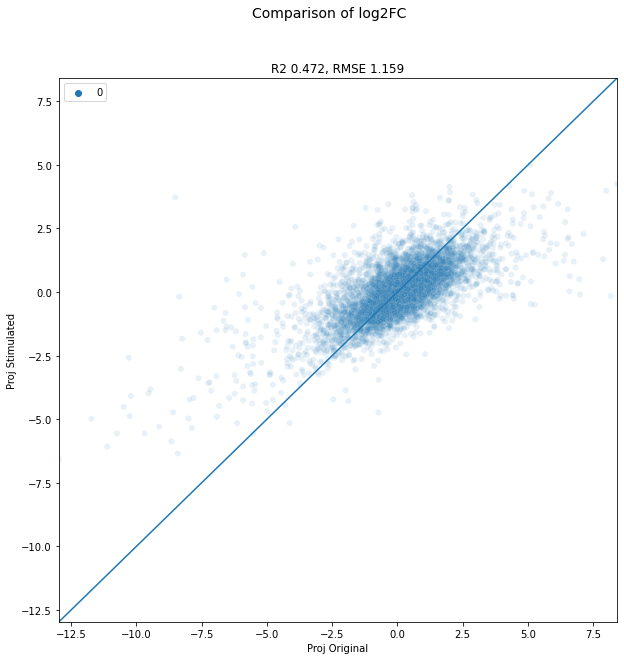

In [ ]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

class_color = [0]*len(b_real_res_df.log2FoldChange)

fig, axs = plt.subplots(1, 1, figsize=(10,10))

real_log2FC = b_real_res_df.log2FoldChange
proj_log2FC = b_proj_res_df.log2FoldChange

a = real_log2FC
b = proj_log2FC
nas = np.logical_or(np.isnan(a), np.isnan(b))

r2_log2FC = np.round(r2_score(a[~nas], b[~nas]), 3)
rmse_log2FC = np.round(np.sqrt(mean_squared_error(a[~nas], b[~nas])), 3)

max_val = np.max([np.max(real_log2FC), np.max(proj_log2FC)])
min_val = np.min([np.min(real_log2FC), np.min(proj_log2FC)])
vp.plot_expr_corr(real_log2FC, proj_log2FC, axs, 
                    title=f"R2 {r2_log2FC}, RMSE {rmse_log2FC}", 
                    xlab="Proj Original", ylab="Proj Stimulated", 
                    class_id=class_color, max_val=max_val, min_val=min_val, alpha=0.1)


fig.suptitle("Comparison of log2FC", fontsize=14)

fig.show()


In [ ]:

# get the DE for each cell type

DE_res_dict = {}


for curr_cell_type in Y_full.columns:
    print(curr_cell_type)

    real_TP_list, proj_TP_list, real_TN_list, proj_TN_list =  get_cell_type_DE(meta_DESeq, de_proj, 
                                                                                de_real, 
                                                                                cell_type_interest=curr_cell_type, 
                                                                                TP_max=3, TN_min=3)
    

    true_pos = (real_TP_list, proj_TP_list)
    false_pos = np.setdiff1d(proj_TP_list, real_TP_list)
    true_neg = real_TN_list

    DE_res_dict[f"real_TP_{curr_cell_type}"] = real_TP_list
    DE_res_dict[f"real_TN_{curr_cell_type}"] = real_TP_list
    DE_res_dict[f"real_TP_{curr_cell_type}"] = real_TP_list
    DE_res_dict[f"real_TP_{curr_cell_type}"] = real_TP_list
    



# now run the realistic ones

B
Fitting size factors...
... done in 0.98 seconds.

Fitting dispersions...
... done in 6.84 seconds.

Fitting dispersion trend curve...
... done in 3.72 seconds.



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:522: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/lib/utils.py:1054: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  result[n] = np.nan


Fitting MAP dispersions...
... done in 6.08 seconds.

Fitting LFCs...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:587: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(


... done in 8.21 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 7.43 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat         pvalue  \
7SK.2           3.910923        2.227432  0.061249  36.366720  1.430089e-289   
A2M             9.173788        0.824994  0.050591  16.307081   8.789384e-60   
A2M-AS1         6.246660       -0.105300  0.042244  -2.492632   1.268002e-02   
A4GALT         21.790943       -0.639490  0.043190 -14.806290   1.334029e-49   
AAAS           98.866952        0.344462  0.037113   9.281374   1.673071e-20   
...                  ...             ...       ...        ...            ...   
ZWILCH         60.591712        0.981651  0.033541  29.267357  2.700583e-188   
ZXDC          119.999639       -0.744283  0.031926 -23.312892  3.280905e-120   
ZYX           320.357350        1.083990  0.055525  19.522481   7.072013e-85   
ZZZ3          120.779004       -0.688556  0.030956 -22.243141  1.314257e-109   
hsa-mir-8072   18.251246        1.695172  0.040536  41.819181   0.000000e+00   

                       padj  
7SK.2         1.056054e-288  
A2M            1.840977e-59  
A2M-AS1        1.394703e-02  
A4GALT         2.572329e-49  
AAAS           2.439866e-20  
...                     ...  
ZWILCH        1.270641e-187  
ZXDC          1.057763e-119  
ZYX            1.769756e-84  
ZZZ3          3.948917e-109  
hsa-mir-8072   0.000000e+00  

[7067 rows x 6 columns]

Fitting size factors...
... done in 0.50 seconds.

Fitting dispersions...
... done in 5.60 seconds.

Fitting dispersion trend curve...
... done in 3.71 seconds.

Fitting MAP dispersions...
... done in 5.57 seconds.

Fitting LFCs...
... done in 9.00 seconds.

Refitting 9 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.09 seconds.

Running Wald tests...
... done in 7.49 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat        pvalue  \
7SK.2           0.556164        1.240612  0.340645   3.641947  2.705837e-04   
A2M             1.989144        0.572815  0.189853   3.017160  2.551549e-03   
A2M-AS1         0.833555        0.131568  0.195261   0.673806  5.004345e-01   
A4GALT        105.480243        0.501504  0.142726   3.513762  4.418091e-04   
AAAS          381.083084        0.606283  0.062445   9.709071  2.758393e-22   
...                  ...             ...       ...        ...           ...   
ZWILCH        385.116694        0.643996  0.053161  12.113949  8.909897e-34   
ZXDC           10.833720       -0.782281  0.124843  -6.266126  3.701403e-10   
ZYX           291.917757        1.223979  0.075157  16.285673  1.247492e-59   
ZZZ3           68.326214       -0.308515  0.094270  -3.272680  1.065330e-03   
hsa-mir-8072   72.188751        0.775058  0.066421  11.668909  1.837655e-31   

                      padj  
7SK.2         3.758374e-04  
A2M           3.339682e-03  
A2M-AS1       5.292899e-01  
A4GALT        6.056308e-04  
AAAS          7.250603e-22  
...                    ...  
ZWILCH        3.070521e-33  
ZXDC          6.693641e-10  
ZYX           7.101185e-59  
ZZZ3          1.425521e-03  
hsa-mir-8072  6.056143e-31  

[7067 rows x 6 columns]

CD14_Mono
Fitting size factors...
... done in 1.00 seconds.



KeyboardInterrupt: 

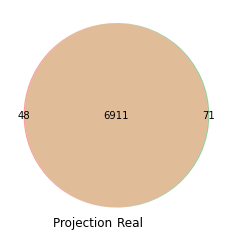

In [ ]:
venn2([set(real_TN_list), set(proj_TN_list)], set_labels = ('Projection ', 'Real '))
plt.show()

In [ ]:
# get the cell type specific expression
# and format it for DESeq

de_proj = pd.DataFrame(cell_type_specific_proj, columns = union_genes)
de_real = pd.DataFrame(cell_type_specific_real, columns = union_genes)

de_proj = de_proj.apply(np.ceil)
de_proj = de_proj.apply(pd.to_numeric)

de_real = de_real.apply(np.ceil)
de_real = de_real.apply(pd.to_numeric)


real_TP_list, proj_TP_list, real_TN_list, proj_TN_list =  get_cell_type_DE(meta_DESeq, de_proj, 
                                                                           de_real, cell_type_interest="B", 
                                                                           TP_max=3, TN_min=3)



Fitting size factors...
... done in 0.97 seconds.

Fitting dispersions...
... done in 6.84 seconds.

Fitting dispersion trend curve...
... done in 3.77 seconds.



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:522: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/lib/utils.py:1054: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  result[n] = np.nan


Fitting MAP dispersions...
... done in 6.18 seconds.

Fitting LFCs...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:587: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(


... done in 9.05 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 7.21 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat         pvalue  \
7SK.2           3.910923        2.227432  0.061249  36.366720  1.430089e-289   
A2M             9.173788        0.824994  0.050591  16.307081   8.789384e-60   
A2M-AS1         6.246660       -0.105300  0.042244  -2.492632   1.268002e-02   
A4GALT         21.790943       -0.639490  0.043190 -14.806290   1.334029e-49   
AAAS           98.866952        0.344462  0.037113   9.281374   1.673071e-20   
...                  ...             ...       ...        ...            ...   
ZWILCH         60.591712        0.981651  0.033541  29.267357  2.700583e-188   
ZXDC          119.999639       -0.744283  0.031926 -23.312892  3.280905e-120   
ZYX           320.357350        1.083990  0.055525  19.522481   7.072013e-85   
ZZZ3          120.779004       -0.688556  0.030956 -22.243141  1.314257e-109   
hsa-mir-8072   18.251246        1.695172  0.040536  41.819181   0.000000e+00   

                       padj  
7SK.2         1.056054e-288  
A2M            1.840977e-59  
A2M-AS1        1.394703e-02  
A4GALT         2.572329e-49  
AAAS           2.439866e-20  
...                     ...  
ZWILCH        1.270641e-187  
ZXDC          1.057763e-119  
ZYX            1.769756e-84  
ZZZ3          3.948917e-109  
hsa-mir-8072   0.000000e+00  

[7067 rows x 6 columns]

Fitting size factors...
... done in 0.50 seconds.

Fitting dispersions...
... done in 5.25 seconds.

Fitting dispersion trend curve...
... done in 3.72 seconds.

Fitting MAP dispersions...
... done in 5.43 seconds.

Fitting LFCs...
... done in 9.11 seconds.

Refitting 9 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.10 seconds.

Running Wald tests...
... done in 7.33 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat        pvalue  \
7SK.2           0.556164        1.240612  0.340645   3.641947  2.705837e-04   
A2M             1.989144        0.572815  0.189853   3.017160  2.551549e-03   
A2M-AS1         0.833555        0.131568  0.195261   0.673806  5.004345e-01   
A4GALT        105.480243        0.501504  0.142726   3.513762  4.418091e-04   
AAAS          381.083084        0.606283  0.062445   9.709071  2.758393e-22   
...                  ...             ...       ...        ...           ...   
ZWILCH        385.116694        0.643996  0.053161  12.113949  8.909897e-34   
ZXDC           10.833720       -0.782281  0.124843  -6.266126  3.701403e-10   
ZYX           291.917757        1.223979  0.075157  16.285673  1.247492e-59   
ZZZ3           68.326214       -0.308515  0.094270  -3.272680  1.065330e-03   
hsa-mir-8072   72.188751        0.775058  0.066421  11.668909  1.837655e-31   

                      padj  
7SK.2         3.758374e-04  
A2M           3.339682e-03  
A2M-AS1       5.292899e-01  
A4GALT        6.056308e-04  
AAAS          7.250603e-22  
...                    ...  
ZWILCH        3.070521e-33  
ZXDC          6.693641e-10  
ZYX           7.101185e-59  
ZZZ3          1.425521e-03  
hsa-mir-8072  6.056143e-31  

[7067 rows x 6 columns]

In [ ]:
de_real

7SK.2  A2M  A2M-AS1  A4GALT    AAAS  AAED1   AAK1   AAMDC    AAMP  \
0        0.0  0.0      0.0     0.0  1266.0  151.0  469.0  1016.0  1049.0   
1        0.0  0.0      0.0     0.0  1731.0  156.0  495.0   856.0  1133.0   
2        0.0  0.0      0.0     0.0  1299.0  171.0  490.0   590.0  1122.0   
3        0.0  0.0      0.0     4.0  1867.0  170.0  391.0   983.0   827.0   
4        5.0  0.0      0.0     4.0  1470.0  165.0  430.0   817.0  1096.0   
...      ...  ...      ...     ...     ...    ...    ...     ...     ...   
11995    0.0  1.0      0.0     0.0    12.0   47.0  645.0     6.0   241.0   
11996    0.0  0.0      0.0     0.0    12.0   23.0  740.0     0.0   223.0   
11997    0.0  0.0      0.0     0.0     6.0   40.0  631.0     0.0   141.0   
11998    0.0  0.0      0.0     0.0     6.0   67.0  904.0     8.0   348.0   
11999    0.0  7.0      0.0     0.0    54.0  395.0  547.0    16.0   799.0   

       AAR2  ...  ZSWIM3  ZSWIM4  ZSWIM6  ZSWIM8   ZW10  ZWILCH  ZXDC    ZYX  \
0       8.0  ...     0.0    42.0   509.0     4.0   21.0   319.0   0.0  113.0   
1      22.0  ...     0.0    20.0   539.0     7.0  186.0   470.0   0.0   99.0   
2       3.0  ...     0.0    92.0   426.0    43.0   13.0   244.0   0.0   99.0   
3       2.0  ...     0.0    61.0   411.0     9.0    9.0   343.0   0.0  105.0   
4       5.0  ...     0.0     4.0   520.0    21.0   24.0   280.0   0.0  128.0   
...     ...  ...     ...     ...     ...     ...    ...     ...   ...    ...   
11995  47.0  ...     6.0     0.0     0.0     2.0    3.0     8.0  31.0   53.0   
11996  29.0  ...     7.0     0.0     0.0     0.0    0.0     0.0   0.0  126.0   
11997  39.0  ...     0.0     3.0     0.0     0.0    0.0     1.0   7.0   96.0   
11998  35.0  ...     0.0     3.0     0.0     2.0    3.0     0.0   5.0  198.0   
11999  36.0  ...    31.0     9.0     0.0     4.0    5.0     1.0  94.0  598.0   

         ZZZ3  hsa-mir-8072  
0         0.0         311.0  
1         0.0         340.0  
2         0.0         336.0  
3         0.0         315.0  
4         0.0         282.0  
...       ...           ...  
11995  1048.0           0.0  
11996  1251.0           0.0  
11997  1431.0           0.0  
11998  1143.0           0.0  
11999   906.0           0.0  

[12000 rows x 7067 columns]

In [ ]:
b_idx = np.where(meta_DESeq.cell_type == "CD14_Mono")[0]
de_proj_b = de_proj.iloc[b_idx,]
meta_DESeq_b = meta_DESeq.iloc[b_idx,]

new_index = ["samp_" + str(s) for s in range(len(b_idx))]
de_proj_b.index = new_index
meta_DESeq_b.index = new_index




In [ ]:
dds_proj_B = DeseqDataSet(
    counts=de_proj_b,
    clinical=meta_DESeq_b,
    design_factors=["cond", "sample_id"],
    refit_cooks=True
)

dds_proj_B.deseq2()

b_proj_res = DeseqStats(dds_proj_B, contrast=["cond", "ctrl", "stim"])

b_proj_res.summary()

Fitting size factors...
... done in 0.99 seconds.

Fitting dispersions...
... done in 7.30 seconds.

Fitting dispersion trend curve...
... done in 4.59 seconds.

Fitting MAP dispersions...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:522: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])


... done in 6.28 seconds.

Fitting LFCs...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:587: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(


... done in 8.58 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 7.51 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat         pvalue  \
7SK.2           2.113459        1.191381  0.063056  18.894136   1.274572e-79   
A2M            12.623193        1.472886  0.054256  27.147094  2.740152e-162   
A2M-AS1         3.981224       -0.109600  0.045618  -2.402528   1.628218e-02   
A4GALT         24.811071       -0.137043  0.043034  -3.184530   1.449893e-03   
AAAS          102.955233        0.474075  0.036307  13.057533   5.756272e-39   
...                  ...             ...       ...        ...            ...   
ZWILCH         37.988053        0.451205  0.031870  14.157772   1.672123e-45   
ZXDC           74.085708       -1.233219  0.034295 -35.959039  3.656084e-283   
ZYX           929.724278        1.045100  0.034181  30.575540  2.588427e-205   
ZZZ3          107.047033       -0.160282  0.031974  -5.012947   5.360270e-07   
hsa-mir-8072   17.323208        2.075015  0.041420  50.096914   0.000000e+00   

                       padj  
7SK.2          3.037910e-79  
A2M           1.068690e-161  
A2M-AS1        1.778182e-02  
A4GALT         1.627962e-03  
AAAS           9.968041e-39  
...                     ...  
ZWILCH         3.088576e-45  
ZXDC          2.660921e-282  
ZYX           1.360031e-204  
ZZZ3           6.440161e-07  
hsa-mir-8072   0.000000e+00  

[7067 rows x 6 columns]

In [ ]:
de_real_b = de_real.iloc[b_idx,]
de_real_b.index = new_index


dds_real_B = DeseqDataSet(
    counts=de_real_b,
    clinical=meta_DESeq_b,
    design_factors=["cond", "sample_id"],
    refit_cooks=True
)

dds_real_B.deseq2()

b_real_res = DeseqStats(dds_real_B, contrast=["cond", "ctrl", "stim"])

b_real_res.summary()


Fitting size factors...
... done in 0.62 seconds.

Fitting dispersions...
... done in 5.39 seconds.

Fitting dispersion trend curve...
... done in 3.81 seconds.

Fitting MAP dispersions...
... done in 5.88 seconds.

Fitting LFCs...
... done in 9.84 seconds.

Refitting 5 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Running Wald tests...
... done in 7.57 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat         pvalue  \
7SK.2          26.335435        1.817295  0.253142   7.178953   7.024745e-13   
A2M             1.970145        0.437288  0.179457   2.436725   1.482094e-02   
A2M-AS1         0.847678        0.022652  0.221227   0.102392   9.184453e-01   
A4GALT         45.656358        3.954983  0.126181  31.343663  1.186930e-215   
AAAS           86.684320        2.061334  0.077230  26.690874  6.007256e-157   
...                  ...             ...       ...        ...            ...   
ZWILCH         18.484149        0.372171  0.108446   3.431850   5.994788e-04   
ZXDC          131.819760       -0.857097  0.116700  -7.344425   2.066450e-13   
ZYX           898.839857        1.249656  0.055087  22.685132  6.281796e-114   
ZZZ3           56.047731       -1.577858  0.108973 -14.479293   1.637719e-47   
hsa-mir-8072   10.287655        0.642836  0.112412   5.718584   1.074153e-08   

                       padj  
7SK.2          1.044183e-12  
A2M            1.705040e-02  
A2M-AS1        9.237138e-01  
A4GALT        8.563722e-215  
AAAS          3.235706e-156  
...                     ...  
ZWILCH         7.291192e-04  
ZXDC           3.099895e-13  
ZYX           2.547961e-113  
ZZZ3           3.689470e-47  
hsa-mir-8072   1.474464e-08  

[7067 rows x 6 columns]

In [ ]:
a = np.array(b_proj_res.results_df.log2FoldChange)
b = b_real_res.results_df.log2FoldChange
nas = np.logical_or(np.isnan(a), np.isnan(b))
pearsonr(a[~nas], b[~nas])


(0.6881940796377121, 0.0)

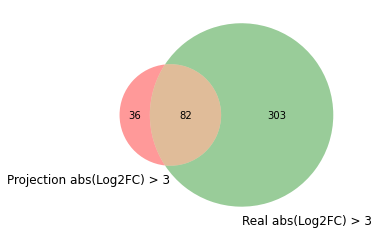

In [ ]:
b_real_res_df = b_real_res.results_df
b_proj_res_df = b_proj_res.results_df

b_real_res_df = b_real_res_df.sort_values(by=['log2FoldChange'])
a = b_real_res_df.iloc[np.where(np.abs(b_real_res_df.log2FoldChange) > 3)[0]]
b_real_res_list = a.index.to_list()

b_proj_res_df = b_proj_res_df.sort_values(by=['log2FoldChange'])
a = b_proj_res_df.iloc[np.where(np.abs(b_proj_res_df.log2FoldChange) > 3)[0]]

b_proj_res_list = a.index.to_list()


venn2([set(b_proj_res_list), set(b_real_res_list)], set_labels = ('Projection abs(Log2FC) > 3', 'Real abs(Log2FC) > 3'))
plt.show()

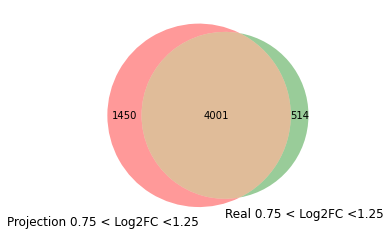

In [ ]:
b_real_res_df = b_real_res.results_df
b_proj_res_df = b_proj_res.results_df


fc_idx = np.where(np.logical_and(b_real_res_df.log2FoldChange <1.25,  
                                 b_real_res_df.log2FoldChange >0.75))[0]
fc_idx = np.where(np.abs(b_real_res_df.log2FoldChange) < 1.1)[0]
a = b_real_res_df.iloc[fc_idx]
b_real_res_list = a.index.to_list()


fc_idx = np.where(np.logical_and(b_proj_res_df.log2FoldChange <1.25,  
                                 b_proj_res_df.log2FoldChange >0.75))[0]
fc_idx = np.where(np.abs(b_proj_res_df.log2FoldChange) < 1.1)[0]
a = b_proj_res_df.iloc[fc_idx]
b_proj_res_list = a.index.to_list()


venn2([set(b_proj_res_list), set(b_real_res_list)], set_labels = ('Projection 0.75 < Log2FC <1.25', 'Real 0.75 < Log2FC <1.25'))
plt.show()